## ANALYSIS ON THE LAGOS REAL ESTATE MARKET - PART 2

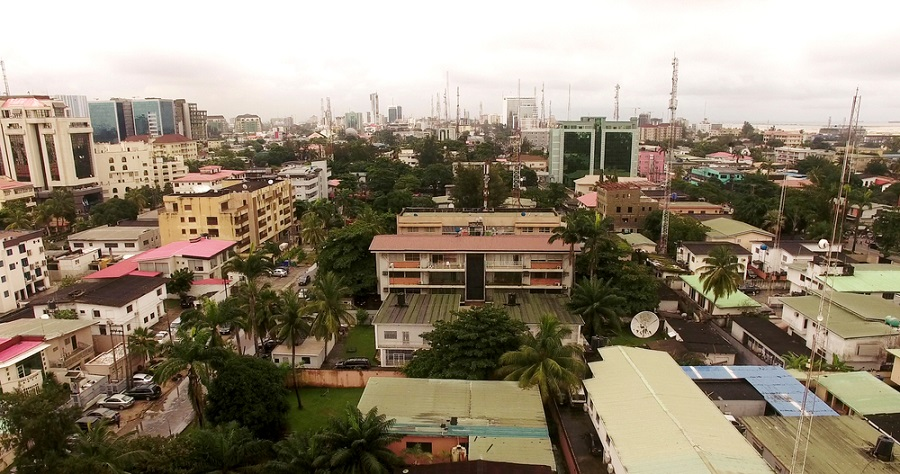

### INTRODUCTION

One major challenge of the traditional real estate market is the infrequent observations/valuations for the same or similar properties.

In developed economies, the use of machine learning and artificial intelligence in the real estate sector are becoming more popular in tackling not only the challenge of property valuation, but also, other services such as facility management, property recommendations, and other automated tasks for higher productivity.

This project seeks to proactively predict property prices listed in classified website advertisements in the Nigerian market.

### PROBLEM STATEMENT

There are multiple real estate classified websites where properties are listed for sale and rent purposes. These online listings have some inconsistencies in their pricing of same or similar properties and this often leads to in-transparency in the market.

Potential buyers, sometimes feel the prices of some listed properties are not justified and they have no alternative platform to confirm or verify. A justified property price model can bring in a lot of transparency and trust back to the property market, especially in Nigeria, where the average volume of a typical transaction is quite high.

This project aims to use machine learning techniques to predict property prices based on certain input features, like number of bedrooms, bathrooms, etc.

### DATA

This project uses publicly available data of property prices in Nigeria from August 2018 to Aug 2020. The data was extracted via scraping the website of a leading Nigerian property firm - Nigeria Property Center (https://nigeriapropertycentre.com), who collates credible property listings.

### DATA ANALYSIS

In [1]:
# import libraries
import os
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression, Ridge, Lasso
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import GridSearchCV
from sklearn.tree import DecisionTreeRegressor
from sklearn.model_selection import ShuffleSplit
from sklearn.model_selection import cross_val_score
import seaborn as sns
sns.set_style("darkgrid")
from matplotlib import pyplot as plt
%matplotlib inline
import matplotlib
matplotlib.rcParams['figure.figsize'] = (20, 10)
import warnings
warnings.filterwarnings('ignore')
import pickle
import json

### Data Cleaning and Feature Engineering

#### Read the data

The data is in two csv files, so merge into one csv then read the data

In [2]:
df1 = pd.read_csv('./data/houses_ngnn.csv')
df1.head()

,description,location,date,bedroom,bathroom,price
0,?,NaN,?,NaN,NaN,NaN
1,3 bedroom terraced duplex for sale,"Airport Road., Lugbe District, Abuja",Added on 08 Jul 2020,3.0,NaN,"23,100,000"
2,5 bedroom detached duplex for sale,"Chevron Alternative, Lekki Phase 2, Lekki, L...",Added on 29 Aug 2020,5.0,5.0,"85,000,000"
3,4 bedroom semi-detached duplex for sale,"Chevron Toll, Lekki Expressway, Lekki, Lagos",Added on 12 Aug 2020,4.0,5.0,"48,000,000"
4,5 bedroom detached duplex for sale,"Lekki Expressway, Lekki, Lagos",Added on 14 Aug 2020,5.0,6.0,"65,000,000"


In [3]:
df1.shape

(16078, 6)

In [4]:
df2 = pd.read_csv('./data/houses_ngnn_two.csv')
df2.head()

,description,location,date,bedroom,bathroom,price
0,?,NaN,?,NaN,NaN,NaN
1,5 bedroom semi-detached duplex for sale,"Old Ikoyi, Ikoyi, Lagos",Added on 06 Jun 2020,5.0,5.0,"250,000,000"
2,4 bedroom semi-detached duplex for sale,"Southern View Estate, Chevron, Second Tollga...",Added on 29 Jul 2020,4.0,4.0,"43,000,000"
3,4 bedroom terraced duplex for sale,"Off Banana Link Road, Old Ikoyi, Ikoyi, Lagos",Added on 29 Jul 2020,4.0,4.0,"155,000,000"
4,5 bedroom detached duplex for sale,"By Southern View Estate, Second Tollgate, La...",Added on 29 Jul 2020,5.0,5.0,"65,000,000"


In [5]:
df2.shape

(22110, 6)

In [6]:
# merge two CSVs
path = "./data"
files = [file for file in os.listdir(path) if not file.startswith('.')] # Ignore hidden files

# define empty dataframe to store all our data
all_homes_data = pd.DataFrame()

for file in files:
    current_data = pd.read_csv(path+"/"+file)
    all_homes_data = pd.concat([all_homes_data, current_data])

all_homes_data.to_csv("./data/all_homes.csv", index=False)

#### Read updated dataframe

In [7]:
pd.set_option('display.float_format', lambda x: '%.2f' % x)

properties_one = pd.DataFrame()

properties_one = pd.read_csv("./data/all_homes.csv")
properties_one.head()

,description,location,date,bedroom,bathroom,price
0,?,NaN,?,nan,nan,NaN
1,3 bedroom terraced duplex for sale,"Airport Road., Lugbe District, Abuja",Added on 08 Jul 2020,3.00,nan,"23,100,000"
2,5 bedroom detached duplex for sale,"Chevron Alternative, Lekki Phase 2, Lekki, L...",Added on 29 Aug 2020,5.00,5.00,"85,000,000"
3,4 bedroom semi-detached duplex for sale,"Chevron Toll, Lekki Expressway, Lekki, Lagos",Added on 12 Aug 2020,4.00,5.00,"48,000,000"
4,5 bedroom detached duplex for sale,"Lekki Expressway, Lekki, Lagos",Added on 14 Aug 2020,5.00,6.00,"65,000,000"


In [8]:
properties_one.shape

(38188, 6)

#### Dealing with null values

Looking at the data, we can see that there are questions marks and null values.
While scraping the data, one of the challenges I faced was that the website had a lot of empty tags which was unaviodably saved with the rest of the data. The question marks were put by me to replace some of the null values.

I would replace all question marks with NaNs and safely drop all null values as they do not represent part of our data

In [9]:
properties_one.replace('?', np.nan, inplace=True)
properties_one.isnull().sum()

description    3329
location       1668
date           3329
bedroom        1668
bathroom       2055
price          1668
dtype: int64

In [10]:
properties_one.dropna(subset=['description', 'date', 'bedroom', "bathroom", "price", "location"], axis=0, inplace=True)

properties_one.isnull().sum()

description    0
location       0
date           0
bedroom        0
bathroom       0
price          0
dtype: int64

In [11]:
# reset index
properties_one = properties_one.reset_index(drop=True)
properties_one.head()

,description,location,date,bedroom,bathroom,price
0,5 bedroom detached duplex for sale,"Chevron Alternative, Lekki Phase 2, Lekki, L...",Added on 29 Aug 2020,5.00,5.00,"85,000,000"
1,4 bedroom semi-detached duplex for sale,"Chevron Toll, Lekki Expressway, Lekki, Lagos",Added on 12 Aug 2020,4.00,5.00,"48,000,000"
2,5 bedroom detached duplex for sale,"Lekki Expressway, Lekki, Lagos",Added on 14 Aug 2020,5.00,6.00,"65,000,000"
3,4 bedroom semi-detached duplex for sale,"Ologolo, Lekki, Lagos",Added on 19 Mar 2019,4.00,5.00,"45,000,000"
4,6 bedroom detached duplex for sale,"Admiralty, Lekki Phase 1, Lekki, Lagos",Added on 19 Jan 2020,6.00,7.00,"270,000,000"


In [12]:
properties_one.shape

(34473, 6)

In [13]:
properties_one.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 34473 entries, 0 to 34472
Data columns (total 6 columns):
 #   Column       Non-Null Count  Dtype  
---  ------       --------------  -----  
 0   description  34473 non-null  object 
 1   location     34473 non-null  object 
 2   date         34473 non-null  object 
 3   bedroom      34473 non-null  float64
 4   bathroom     34473 non-null  float64
 5   price        34473 non-null  object 
dtypes: float64(2), object(4)
memory usage: 1.6+ MB


#### Convert price column from object to float

In [14]:
# Remove commas from the price column
properties_one['price'] = properties_one['price'].apply(lambda x: x.replace(',','').strip())

# Convert price variable to numeric
properties_one["price"] = pd.to_numeric(properties_one["price"], downcast="float")

In [15]:
properties_one.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 34473 entries, 0 to 34472
Data columns (total 6 columns):
 #   Column       Non-Null Count  Dtype  
---  ------       --------------  -----  
 0   description  34473 non-null  object 
 1   location     34473 non-null  object 
 2   date         34473 non-null  object 
 3   bedroom      34473 non-null  float64
 4   bathroom     34473 non-null  float64
 5   price        34473 non-null  float32
dtypes: float32(1), float64(2), object(3)
memory usage: 1.4+ MB


### Select rows containing lagos and create new dataframe

In [16]:
properties_two = properties_one[properties_one['location'].str.contains('Lagos|lagos')]
properties_two.head()

,description,location,date,bedroom,bathroom,price
0,5 bedroom detached duplex for sale,"Chevron Alternative, Lekki Phase 2, Lekki, L...",Added on 29 Aug 2020,5.00,5.00,85000000.00
1,4 bedroom semi-detached duplex for sale,"Chevron Toll, Lekki Expressway, Lekki, Lagos",Added on 12 Aug 2020,4.00,5.00,48000000.00
2,5 bedroom detached duplex for sale,"Lekki Expressway, Lekki, Lagos",Added on 14 Aug 2020,5.00,6.00,65000000.00
3,4 bedroom semi-detached duplex for sale,"Ologolo, Lekki, Lagos",Added on 19 Mar 2019,4.00,5.00,45000000.00
4,6 bedroom detached duplex for sale,"Admiralty, Lekki Phase 1, Lekki, Lagos",Added on 19 Jan 2020,6.00,7.00,270000000.00


In [17]:
# View summary of the data
print("Rows   :", properties_two.shape[0])
print("Columns:", properties_two.shape[1])
print("\nFeatures:", properties_two.columns.tolist())
print("\nMissing values:", properties_two.isnull().sum().values.sum())
print('\nUnique values: \n', properties_two.nunique())

Rows   : 28750
Columns: 6

Features: ['description', 'location', 'date', 'bedroom', 'bathroom', 'price']

Missing values: 0

Unique values: 
 description     165
location       9508
date            724
bedroom          51
bathroom         47
price           568
dtype: int64


#### Work on description column and create new "type" column

If we look at the description column, we can see a pattern, each row starts with the number of bedrooms followed by the type, e.g. duplex, flats, etc, and lastly "for sale".

In Nigeria, the type of property is very important in making decisions when doing real estate transactions, hence I would create a new column which contains only the type of the property.
See example of the first row:

5 bedroom detached duplex for sale

In [18]:
# Let's use .apply()
def get_spec(types):
    return types.split(' ')[2].strip()

def get_type(types):
    return types.split(' ')[-3].strip()

properties_two['types'] = properties_two['description'].apply(lambda x: get_spec(x) + "_" + get_type(x))

In [19]:
properties_two.head()

,description,location,date,bedroom,bathroom,price,types
0,5 bedroom detached duplex for sale,"Chevron Alternative, Lekki Phase 2, Lekki, L...",Added on 29 Aug 2020,5.00,5.00,85000000.00,detached_duplex
1,4 bedroom semi-detached duplex for sale,"Chevron Toll, Lekki Expressway, Lekki, Lagos",Added on 12 Aug 2020,4.00,5.00,48000000.00,semi-detached_duplex
2,5 bedroom detached duplex for sale,"Lekki Expressway, Lekki, Lagos",Added on 14 Aug 2020,5.00,6.00,65000000.00,detached_duplex
3,4 bedroom semi-detached duplex for sale,"Ologolo, Lekki, Lagos",Added on 19 Mar 2019,4.00,5.00,45000000.00,semi-detached_duplex
4,6 bedroom detached duplex for sale,"Admiralty, Lekki Phase 1, Lekki, Lagos",Added on 19 Jan 2020,6.00,7.00,270000000.00,detached_duplex


#### Dimensionality reduction and creation of town, city, and state columns from location column

The location of a property is one of the most important factors considered when a evaluating a property.
In Nigeria, location is taken very seriously, even up to the granular level, the street/estate/town, the town and the city matters. 

I would extract these information from the location column and put them in their respective columns

In [20]:
# unique location values
len(properties_two['location'].unique().tolist())

9508

In [21]:
# Let's use .apply()

properties_two['town'] = properties_two['location'].apply(lambda x: x.split(",")[-3].strip() if len(x.split(',')) > 2 else (x.split(",")[-2].strip() if len(x.split(',')) > 1 else x.split(",")[-1].strip()))
properties_two['city'] = properties_two['location'].apply(lambda x: x.split(',')[-2].strip() if len(x.split(',')) > 1 else x.split(",")[-1].strip())

In [22]:
properties_two.sample(10)

,description,location,date,bedroom,bathroom,price,types,town,city
22670,3 bedroom block of flats for sale,"Ire Akari, Isolo, Lagos",Added on 05 Aug 2020,3.00,3.00,48000000.00,block_flats,Ire Akari,Isolo
7176,3 bedroom detached bungalow for sale,"Balogun Estate, Directly Facing Fara Park, M...",Added on 18 Jul 2020,3.00,3.00,27000000.00,detached_bungalow,Sangotedo,Ajah
7758,4 bedroom terraced duplex for sale,"Off Queens Drive, Ikoyi, Lagos",Added on 08 Jul 2020,4.00,4.00,260000000.00,terraced_duplex,Off Queens Drive,Ikoyi
33361,Block of flats for sale,"Durbar Estate, Amuwo Odofin, Lagos",Added on 02 Apr 2019,4.00,4.00,200000000.00,flats_flats,Durbar Estate,Amuwo Odofin
22946,5 bedroom terraced duplex for sale,"Awoyaya, Ibeju Lekki, Lagos",Added on 31 Jul 2020,5.00,4.00,37000000.00,terraced_duplex,Awoyaya,Ibeju Lekki
5070,4 bedroom detached duplex for sale,"Phase 1, GRA, Magodo, Lagos",Added on 16 May 2020,4.00,4.00,77000000.00,detached_duplex,GRA,Magodo
8044,4 bedroom block of flats for sale,"Ikoyi, Lagos",Added on 08 Mar 2020,4.00,4.00,460000000.00,block_flats,Ikoyi,Ikoyi
30337,5 bedroom detached duplex for sale,"Chevy View Estate, Lekki, Lagos",Added on 10 Dec 2018,5.00,5.00,80000000.00,detached_duplex,Chevy View Estate,Lekki
33736,5 bedroom detached duplex for sale,"Chevy View Estate, Lekki, Lagos",Added on 05 Feb 2019,5.00,6.00,85000000.00,detached_duplex,Chevy View Estate,Lekki
31892,4 bedroom semi-detached duplex for sale,"Off Admiralty Road, Lekki Phase 1, Lekki, Lagos",Added on 16 Sep 2019,4.00,4.00,100000000.00,semi-detached_duplex,Lekki Phase 1,Lekki


#### Explore the city column

Let's check to see the cities that have a small data points and drop them.

In [23]:
city_stats = properties_two.groupby('city')['city'].agg('count').sort_values(ascending=False)

city_less_than_40 = city_stats[city_stats <= 40]

city_less_than_40

city
Ejigbo                                38
Ayobo                                 31
Shomolu                               30
Isheri                                26
Idimu                                 25
Apapa                                 25
Oshodi                                24
Kosofe                                22
Mushin                                21
Badagry                               17
Ibeju                                 17
Oke-Odo                               16
Lagos Island                          14
Epe                                   14
Eko Atlantic City                     14
Arepo                                 10
Ado-Odo/Ota                           10
Agbara-Igbesa                          9
Egbe                                   7
Ojota                                  6
Mowe Ofada                             6
Ijede                                  5
Magboro                                5
Ibafo                                  5
KM 46      

In [24]:
# Replace all states with less than 30 data points

properties_two.city = properties_two.city.apply(lambda x: np.nan if x in city_less_than_40 else x)

In [25]:
properties_two.isnull().sum()

description      0
location         0
date             0
bedroom          0
bathroom         0
price            0
types            0
town             0
city           420
dtype: int64

In [26]:
properties_two.dropna(subset=['city'], axis=0, inplace=True)

properties_two.isnull().sum()

description    0
location       0
date           0
bedroom        0
bathroom       0
price          0
types          0
town           0
city           0
dtype: int64

In [27]:
check_city = properties_two.groupby("city", as_index=True)[["town"]].count()
check_city

,town
city,
Agege,220
Ajah,2961
Alimosho,238
Amuwo Odofin,87
Gbagada,173
Ibeju Lekki,803
Ifako-Ijaiye,72
Ijaiye,41
Ikeja,1207


#### Explore the town column

Let's check to see the towns that have a small data points and drop them.

In [28]:
location_stats = properties_two.groupby('town')['town'].agg('count').sort_values(ascending=True)
location_stats.head(20)

town
pinnock Beach Estate                  1
Lagos States                          1
Lagos Bussiness School Axis           1
Lagos Bussiness School                1
Lagos Business School.                1
Premier                               1
Lagoone Estate                        1
Lagoon Estate                         1
Lagbansa                              1
Lagos _ Ibadan Express-way            1
Lafija Orchid Road By 2nd Tollgate    1
Lafiaji Road                          1
Lafiaji Community                     1
Prime Plus Estate                     1
Labora Town Beside Abijo Gra          1
L B S                                 1
Kota Villa Estate Rd 32.              1
Kola Ajegunle                         1
Kokoro Abu                            1
Lafiaji.                              1
Name: town, dtype: int64

In [29]:
town_less_than_30 = location_stats[location_stats <= 30]

town_less_than_30

town
pinnock Beach Estate            1
Lagos States                    1
Lagos Bussiness School Axis     1
Lagos Bussiness School          1
Lagos Business School.          1
                               ..
Akowonjo                       29
Orchid Hotel Road              29
Alapere                        29
Lekki County                   29
Adelabu                        30
Name: town, Length: 1775, dtype: int64

In [30]:
# Replace all towns with less than 30 data points

properties_two.town = properties_two.town.apply(lambda x: np.nan if x in town_less_than_30 else x)

In [31]:
properties_two.isnull().sum()

description       0
location          0
date              0
bedroom           0
bathroom          0
price             0
types             0
town           4056
city              0
dtype: int64

In [32]:
properties_two.dropna(subset=['town'], axis=0, inplace=True)

# reset index
properties_two = properties_two.reset_index(drop=True)

properties_two.isnull().sum()

description    0
location       0
date           0
bedroom        0
bathroom       0
price          0
types          0
town           0
city           0
dtype: int64

In [33]:
len(properties_two['town'].unique().tolist())

93

#### Creating a new area column

This column would be a combination of the town and city which would represent our new location

In [34]:
properties_two['area'] = properties_two['town'] +" "+ properties_two['city']

In [35]:
properties_two.head()

,description,location,date,bedroom,bathroom,price,types,town,city,area
0,5 bedroom detached duplex for sale,"Chevron Alternative, Lekki Phase 2, Lekki, L...",Added on 29 Aug 2020,5.00,5.00,85000000.00,detached_duplex,Lekki Phase 2,Lekki,Lekki Phase 2 Lekki
1,4 bedroom semi-detached duplex for sale,"Chevron Toll, Lekki Expressway, Lekki, Lagos",Added on 12 Aug 2020,4.00,5.00,48000000.00,semi-detached_duplex,Lekki Expressway,Lekki,Lekki Expressway Lekki
2,5 bedroom detached duplex for sale,"Lekki Expressway, Lekki, Lagos",Added on 14 Aug 2020,5.00,6.00,65000000.00,detached_duplex,Lekki Expressway,Lekki,Lekki Expressway Lekki
3,4 bedroom semi-detached duplex for sale,"Ologolo, Lekki, Lagos",Added on 19 Mar 2019,4.00,5.00,45000000.00,semi-detached_duplex,Ologolo,Lekki,Ologolo Lekki
4,6 bedroom detached duplex for sale,"Admiralty, Lekki Phase 1, Lekki, Lagos",Added on 19 Jan 2020,6.00,7.00,270000000.00,detached_duplex,Lekki Phase 1,Lekki,Lekki Phase 1 Lekki


In [36]:
len(properties_two['area'].unique().tolist())

147

#### Drop columns we do not need for this analysis

In [37]:
properties_three = properties_two.drop(["description", "location", "date", "city", "town"], axis="columns")

properties_three.head()

,bedroom,bathroom,price,types,area
0,5.00,5.00,85000000.00,detached_duplex,Lekki Phase 2 Lekki
1,4.00,5.00,48000000.00,semi-detached_duplex,Lekki Expressway Lekki
2,5.00,6.00,65000000.00,detached_duplex,Lekki Expressway Lekki
3,4.00,5.00,45000000.00,semi-detached_duplex,Ologolo Lekki
4,6.00,7.00,270000000.00,detached_duplex,Lekki Phase 1 Lekki


In [38]:
properties_three['area'].unique().tolist()

['Lekki Phase 2 Lekki',
 'Lekki Expressway Lekki',
 'Ologolo Lekki',
 'Lekki Phase 1 Lekki',
 'Ajiwe Ajah',
 'Lafiaji Lekki',
 'Ikate Lekki',
 'Ikota Lekki',
 'Oniru Victoria Island (VI)',
 'Banana Island Ikoyi',
 'GRA Ogudu',
 'Chevron Lekki',
 'Chevron Drive Lekki',
 'Osapa Lekki',
 'Omole Phase 1 Ikeja',
 '2nd Toll Gate Lekki',
 'Nicon Town Lekki',
 'Idado Lekki',
 'Ikate Elegushi Lekki',
 'Old Ikoyi Ikoyi',
 'VGC Lekki',
 'Igando Ikotun',
 'Parkview Ikoyi',
 'GRA Magodo',
 'Sangotedo Ajah',
 'Opic Isheri North',
 'Omole Phase 2 Ikeja',
 'Badore Ajah',
 'Ikoyi Ikoyi',
 'Agungi Lekki',
 'Chevy View Estate Lekki',
 'Ikeja GRA Ikeja',
 'Opebi Ikeja',
 'Adeniyi Jones Ikeja',
 'Ajah Lekki',
 'Ikoyi Lekki',
 'Allen Ikeja',
 'Orchid Road Lekki',
 'Thomas Estate Ajah',
 'Ilasan Lekki',
 'Ajah Ajah',
 'Bogije Ibeju Lekki',
 'Abijo Lekki',
 'Abule Egba Agege',
 'Ado Ajah',
 'Ogombo Ajah',
 'Abraham Adesanya Ajah',
 'Chevron Alternative Route Lekki',
 'Ifako Gbagada',
 'Osborne Ikoyi',
 'Ijegu

In [39]:
len(properties_three['area'].unique().tolist())

147

In [40]:
# because of repitition
properties_three.loc[properties_three['area'].str.contains('Oniru', case=False), 'area'] = 'Oniru Vi'

In [41]:
oniru = properties_three[properties_three['area'].str.contains('Oniru')]
oniru.head(6)

,bedroom,bathroom,price,types,area
11,4.00,4.00,150000000.00,terraced_duplex,Oniru Vi
286,4.00,4.00,120000000.00,terraced_duplex,Oniru Vi
397,5.00,5.00,150000000.00,terraced_duplex,Oniru Vi
403,3.00,3.00,60000000.00,house_house,Oniru Vi
558,3.00,3.00,700000000.00,block_flats,Oniru Vi
671,4.00,5.00,100000000.00,detached_duplex,Oniru Vi


In [42]:
# because of repitition
properties_three.loc[properties_three['area'].str.contains('Victoria Island', case=False), 'area'] = 'Victoria Island'
properties_three.loc[properties_three['area'].str.contains('Chevron', case=False), 'area'] = 'Chervon Lekki'
properties_three.loc[properties_three['area'].str.contains('VGC', case=False), 'area'] = 'Vgc Ajah'
properties_three.loc[properties_three['area'].str.contains('Abraham Adesanya', case=False), 'area'] = 'Abraham Adesanya Ajah'
properties_three.loc[properties_three['area'].str.contains('Sangotedo', case=False), 'area'] = 'Sangotedo Ajah'
properties_three.loc[properties_three['area'].str.contains('Osapa', case=False), 'area'] = 'Osapa London Lekki'
properties_three.loc[properties_three['area'].str.contains('Chevy View', case=False), 'area'] = 'Chevy View Estate Ajah'
properties_three.loc[properties_three['area'].str.contains('Lekki Phase 1', case=False), 'area'] = 'Lekki Phase 1'
properties_three.loc[properties_three['area'].str.contains('2nd Toll Gate', case=False), 'area'] = '2nd Toll Gate Lekki'
properties_three.loc[properties_three['area'].str.contains('Badore', case=False), 'area'] = 'Badore Ajah'
properties_three.loc[properties_three['area'].str.contains('Ikota', case=False), 'area'] = 'Ikota Ajah'
properties_three.loc[properties_three['area'].str.contains('Bogije', case=False), 'area'] = 'Bogije Ibeju Lekki'
properties_three.loc[properties_three['area'].str.contains('Abijo', case=False), 'area'] = 'Abijo Ibeju Lekki'
properties_three.loc[properties_three['area'].str.match(' Ajah|Ajah Lekki|Lekki Ajah|Ajah Ajah', case=False), 'area'] = 'Ajah'
properties_three.loc[properties_three['area'].str.match('Ikoyi Ikoyi|Ikoyi Lekki', case=False), 'area'] = 'Ikoyi'
properties_three.loc[properties_three['area'].str.match(' Lekki|Lekki Lekki', case=False), 'area'] = 'Lekki'
properties_three.loc[properties_three['area'].str.contains('Awoyaya', case=False), 'area'] = 'Awoyaya Ibeju Lekki'
properties_three.loc[properties_three['area'].str.contains('Lakowe', case=False), 'area'] = 'Lakowe Ibeju Lekki'
properties_three.loc[properties_three['area'].str.match('Ikate Lekki|Ikate Elegushi Lekki', case=False), 'area'] = 'Ikate Lekki'

In [43]:
properties_three.loc[properties_three['area'].str.match('GRA Ogudu', case=False), 'area'] = 'G R A Ogudu'
properties_three.loc[properties_three['area'].str.match('GRA Magodo', case=False), 'area'] = 'G R A Magodo'
properties_three.loc[properties_three['area'].str.match('GRA Isheri North', case=False), 'area'] = 'G R A Isheri North'
properties_three.loc[properties_three['area'].str.match('Ikeja GRA Ikeja', case=False), 'area'] = 'G R A Ikeja'

properties_three.loc[properties_three['area'].str.match('Oko-oba Agege', case=False), 'area'] = 'Oko Oba Agege'
properties_three.loc[properties_three['area'].str.match(' Ipaja', case=False), 'area'] = 'Ipaja'
properties_three.loc[properties_three['area'].str.match('Abule Egba Ifako-Ijaiye', case=False), 'area'] = 'Abule Egba Ifako Ijaiye'
properties_three.loc[properties_three['area'].str.match(' Yaba', case=False), 'area'] = 'Yaba'
properties_three.loc[properties_three['area'].str.match(' Alimosho', case=False), 'area'] = 'Alimosho'
properties_three.loc[properties_three['area'].str.match(' Gbagada', case=False), 'area'] = 'Gbagada'
properties_three.loc[properties_three['area'].str.match(' Surulere', case=False), 'area'] = 'Surulere'
properties_three.loc[properties_three['area'].str.match(' Ikorodu', case=False), 'area'] = 'Ikorodu'
properties_three.loc[properties_three['area'].str.match(' Ojodu', case=False), 'area'] = 'Ojodu'
properties_three.loc[properties_three['area'].str.match('Alagbado Ifako-Ijaiye', case=False), 'area'] = 'Alagbado Ifako Ijaiye'

In [44]:
len(properties_three['area'].unique().tolist())

111

In [45]:
properties_three['area'].unique().tolist()

['Lekki Phase 2 Lekki',
 'Lekki Expressway Lekki',
 'Ologolo Lekki',
 'Lekki Phase 1',
 'Ajiwe Ajah',
 'Lafiaji Lekki',
 'Ikate Lekki',
 'Ikota Ajah',
 'Oniru Vi',
 'Banana Island Ikoyi',
 'G R A Ogudu',
 'Chervon Lekki',
 'Osapa London Lekki',
 'Omole Phase 1 Ikeja',
 '2nd Toll Gate Lekki',
 'Nicon Town Lekki',
 'Idado Lekki',
 'Old Ikoyi Ikoyi',
 'Vgc Ajah',
 'Igando Ikotun',
 'Parkview Ikoyi',
 'G R A Magodo',
 'Sangotedo Ajah',
 'Opic Isheri North',
 'Omole Phase 2 Ikeja',
 'Badore Ajah',
 'Ikoyi',
 'Agungi Lekki',
 'Chevy View Estate Ajah',
 'G R A Ikeja',
 'Opebi Ikeja',
 'Adeniyi Jones Ikeja',
 'Ajah',
 'Allen Ikeja',
 'Orchid Road Lekki',
 'Thomas Estate Ajah',
 'Ilasan Lekki',
 'Bogije Ibeju Lekki',
 'Abijo Ibeju Lekki',
 'Abule Egba Agege',
 'Ado Ajah',
 'Ogombo Ajah',
 'Abraham Adesanya Ajah',
 'Ifako Gbagada',
 'Osborne Ikoyi',
 'Ijegun Ikotun',
 'Ilaje Ajah',
 'Aguda Surulere',
 'Okokomaiko Ojo',
 'Jakande Lekki',
 'Igbo Efon Lekki',
 'Lekki',
 'Oko Oba Agege',
 'Victoria 

In [46]:
# remove hyphen from house types
properties_three.loc[properties_three['types'].str.match('semi-detached_duplex', case=False), 'types'] = 'semi_detached_duplex'
properties_three.loc[properties_three['types'].str.match('semi-detached_bungalow', case=False), 'types'] = 'semi_detached_bungalow'
properties_three.loc[properties_three['types'].str.match('flats_flats', case=False), 'types'] = 'flats'
properties_three.loc[properties_three['types'].str.match('for_bungalow', case=False), 'types'] = 'bungalow'
properties_three.loc[properties_three['types'].str.match('for_duplex', case=False), 'types'] = 'duplex'

In [47]:
# move type and area columns to the left, just my preference

cols_to_move = ['types', 'area']
properties_three = properties_three[cols_to_move + [ col for col in properties_three.columns if col not in cols_to_move ]]

In [48]:
properties_three.sample(10)

,types,area,bedroom,bathroom,price
23455,detached_duplex,Ilaje Ajah,4.00,3.00,45000000.00
21330,terraced_duplex,Sangotedo Ajah,2.00,2.00,26000000.00
7645,terraced_duplex,Lekki Phase 1,4.00,4.00,180000000.00
9207,terraced_duplex,Ilaje Ajah,4.00,5.00,50000000.00
10710,semi_detached_duplex,Ogombo Ajah,4.00,4.00,55000000.00
22072,detached_duplex,Eleko Ibeju Lekki,4.00,4.00,60000000.00
20010,detached_bungalow,Bogije Ibeju Lekki,3.00,3.00,14500000.00
13838,detached_duplex,Banana Island Ikoyi,5.00,4.00,900000000.00
12522,semi_detached_duplex,Vgc Ajah,4.00,4.00,40000.00
5173,detached_duplex,Omole Phase 1 Ikeja,4.00,4.00,135000000.00


In [49]:
# View summary of the data
print("Rows   :", properties_three.shape[0])
print("Columns:", properties_three.shape[1])
print("\nFeatures:", properties_three.columns.tolist())
print("\nMissing values:", properties_three.isnull().sum().values.sum())
print('\nUnique values: \n', properties_three.nunique())

Rows   : 24274
Columns: 5

Features: ['types', 'area', 'bedroom', 'bathroom', 'price']

Missing values: 0

Unique values: 
 types        12
area        111
bedroom      42
bathroom     39
price       505
dtype: int64


### Outlier Detection and Removal

Reason for removing flats here!!!

In [50]:
types_stats = properties_three.groupby('types')['types'].agg('count').sort_values(ascending=True)
types_stats

types
bungalow                    58
sale_House                  72
terraced_bungalow           79
semi_detached_bungalow     235
flats                      240
duplex                     342
detached_bungalow          577
house_house                971
block_flats               1333
terraced_duplex           4805
semi_detached_duplex      6187
detached_duplex           9375
Name: types, dtype: int64

In [51]:
len(properties_three['types'].unique().tolist())

12

In [52]:
blocks_of_flats = properties_three[properties_three['types'].str.contains('block_flats')]
blocks_of_flats.head(10)

,types,area,bedroom,bathroom,price
42,block_flats,Old Ikoyi Ikoyi,4.00,4.00,200000000.00
44,block_flats,Lekki Phase 1,3.00,3.00,35000000.00
50,block_flats,Igando Ikotun,16.00,16.00,28000000.00
68,block_flats,Ikate Lekki,2.00,2.00,32000000.00
70,block_flats,Omole Phase 2 Ikeja,3.00,3.00,130000000.00
80,block_flats,Lekki Phase 1,2.00,2.00,25000000.00
139,block_flats,G R A Ikeja,3.00,3.00,80000000.00
146,block_flats,Allen Ikeja,3.00,3.00,250000000.00
154,block_flats,Lekki Phase 1,2.00,2.00,25000000.00
182,block_flats,Vgc Ajah,2.00,2.00,250000000.00


In [53]:
all_flats = properties_three[properties_three['types'].str.match('flats')]
all_flats.sample(10)

,types,area,bedroom,bathroom,price
18775,flats,Anthony Maryland,5.00,5.00,135000000.00
18395,flats,Ikate Lekki,5.00,4.00,320000000.00
20773,flats,Badore Ajah,3.00,5.00,110000000.00
11345,flats,Gbagada Phase 1 Gbagada,4.00,4.00,55000000.00
10673,flats,Lekki Phase 1,4.00,4.00,260000000.00
12743,flats,Ebute Ikorodu,4.00,4.00,22000000.00
14519,flats,G R A Magodo,5.00,5.00,150000000.00
8016,flats,Maryland Maryland,5.00,6.00,600000000.00
7200,flats,Anthony Maryland,2.00,2.00,50000000.00
10275,flats,Igbogbo Ikorodu,4.00,4.00,8000000.00


In [54]:
properties_four = properties_three[~properties_three['types'].str.match('block_flats|flats')]

properties_four.head()

,types,area,bedroom,bathroom,price
0,detached_duplex,Lekki Phase 2 Lekki,5.00,5.00,85000000.00
1,semi_detached_duplex,Lekki Expressway Lekki,4.00,5.00,48000000.00
2,detached_duplex,Lekki Expressway Lekki,5.00,6.00,65000000.00
3,semi_detached_duplex,Ologolo Lekki,4.00,5.00,45000000.00
4,detached_duplex,Lekki Phase 1,6.00,7.00,270000000.00


In [55]:
# because of repitition
properties_four.loc[properties_four['types'].str.contains('house', case=False), 'types'] = 'house'

In [56]:
types_stats = properties_four.groupby('types')['types'].agg('count').sort_values(ascending=True)
types_stats

types
bungalow                    58
terraced_bungalow           79
semi_detached_bungalow     235
duplex                     342
detached_bungalow          577
house                     1043
terraced_duplex           4805
semi_detached_duplex      6187
detached_duplex           9375
Name: types, dtype: int64

In [57]:
len(properties_four['types'].unique().tolist())

9

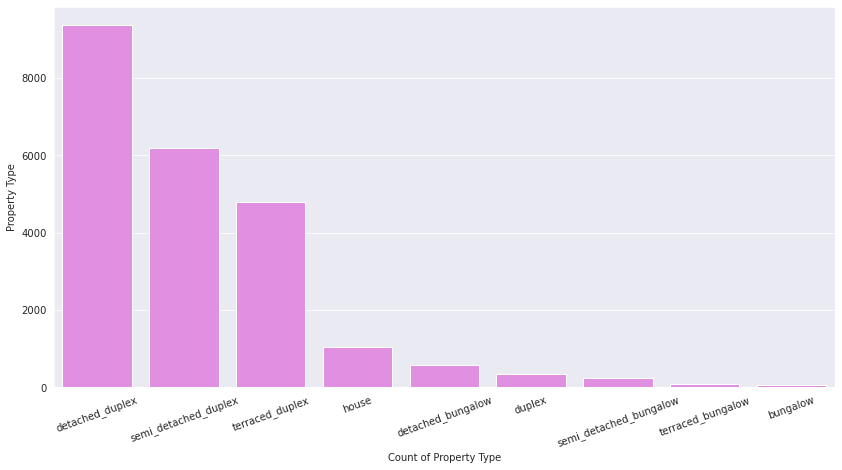

In [58]:
fig, ax = plt.subplots(figsize=(14, 7))
sns.barplot(x = properties_four['types'].value_counts().index, y = properties_four['types'].value_counts(),color = 'violet')
plt.xticks(rotation=20)
plt.xlabel("Count of Property Type")
plt.ylabel("Property Type")
#plt.title(area)
plt.show()

In [59]:
# View summary of the data
print("Rows   :", properties_four.shape[0])
print("Columns:", properties_four.shape[1])
print("\nFeatures:", properties_four.columns.tolist())
print("\nMissing values:", properties_four.isnull().sum().values.sum())
print('\nUnique values: \n', properties_four.nunique())

Rows   : 22701
Columns: 5

Features: ['types', 'area', 'bedroom', 'bathroom', 'price']

Missing values: 0

Unique values: 
 types         9
area        106
bedroom      34
bathroom     32
price       452
dtype: int64


#### Outlier Detection and removal using percentile and boxplot

In [60]:
# summary statistics of the data
properties_four.describe()

,bedroom,bathroom,price
count,22701.00,22701.00,22701.00
mean,4.42,4.60,148757328.00
std,2.11,1.92,2137700224.00
min,1.00,1.00,1.00
25%,4.00,4.00,50000000.00
50%,4.00,4.00,70000000.00
75%,5.00,5.00,120000000.00
max,123.00,120.00,260000006144.00


Looking at the statistics for the bedroom and bathroom columns above, we can see that about 75 percent of our data is 5. However, we have maximum values of 123 and 120 for the bedroom and bathroom columns, respectively.

These data points are not errors, as there are houses with over 50-100 bedrooms for sale in Nigeria. However, these data points are very different from the majority of the data points in our dataset and can skew the statistical power of the data analysis process.

Based on the above explanation, I would remove outliers from the dataset.

NB: An outlier would be any datapoints (in the bedroom/bathroom columns) above 99 percent quantile and below 1 percent quantile.

#### Boxplot Illustration

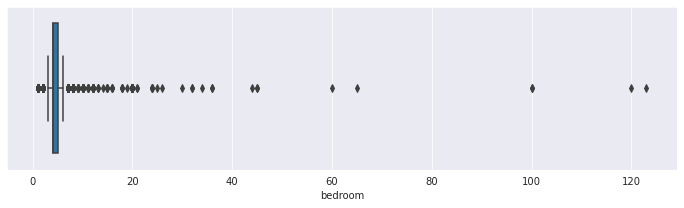

In [61]:
# For bedroom
fig, ax = plt.subplots(figsize=(12, 3))
sns.boxplot(x='bedroom', data=properties_four)
plt.show()

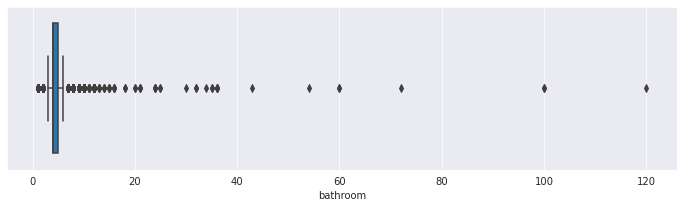

In [62]:
# For bathroom
fig, ax = plt.subplots(figsize=(12, 3))
sns.boxplot(x='bathroom', data=properties_four)
plt.show()

In [63]:
min_bed_threshold, max_bed_threshold = properties_four['bedroom'].quantile([0.01, 0.99])
min_bed_threshold, max_bed_threshold

(2.0, 8.0)

In [64]:
min_bath_threshold, max_bath_threshold = properties_four['bathroom'].quantile([0.01, 0.99])
min_bath_threshold, max_bath_threshold

(2.0, 8.0)

In [65]:
properties_four[properties_four['bedroom'] > max_bed_threshold]

,types,area,bedroom,bathroom,price
194,terraced_duplex,Lekki Phase 1,20.00,4.00,100000000.00
269,semi_detached_duplex,Ologolo Lekki,10.00,10.00,70000000.00
291,terraced_duplex,Lekki Phase 1,20.00,4.00,100000000.00
549,terraced_duplex,Lekki Phase 1,20.00,4.00,100000000.00
640,terraced_duplex,Lekki Phase 1,20.00,4.00,100000000.00
...,...,...,...,...,...
24087,detached_duplex,Ago Palace Isolo,9.00,5.00,75000000.00
24140,semi_detached_duplex,Banana Island Ikoyi,10.00,14.00,830000000.00
24234,terraced_duplex,Lekki Phase 1,20.00,4.00,100000000.00
24241,terraced_duplex,Lekki Phase 1,20.00,4.00,100000000.00


In [66]:
properties_four[properties_four['bathroom'] > max_bath_threshold]

,types,area,bedroom,bathroom,price
237,terraced_duplex,Vgc Ajah,2.00,32.00,30000000.00
269,semi_detached_duplex,Ologolo Lekki,10.00,10.00,70000000.00
520,detached_duplex,Osborne Ikoyi,8.00,11.00,800000000.00
683,detached_duplex,Lekki Phase 1,7.00,9.00,440000000.00
743,terraced_duplex,Ikota Ajah,4.00,21.00,38000000.00
...,...,...,...,...,...
23597,detached_duplex,Victoria Island,15.00,20.00,300000000.00
23946,detached_duplex,Fagba Agege,12.00,14.00,56000000.00
23993,house,Opebi Ikeja,10.00,10.00,950000000.00
24140,semi_detached_duplex,Banana Island Ikoyi,10.00,14.00,830000000.00


#### For price

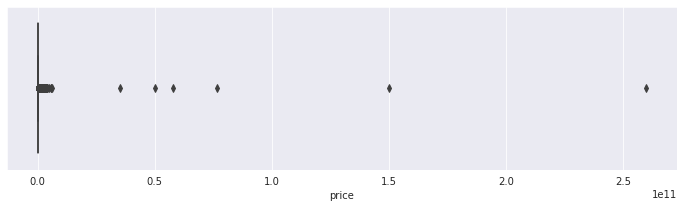

In [67]:
# For price
fig, ax = plt.subplots(figsize=(12, 3))
sns.boxplot(x='price', data=properties_four)
plt.show()

In [68]:
min_price_threshold, max_price_threshold = properties_four['price'].quantile([0.01, 0.99])
min_price_threshold, max_price_threshold

(13950000.0, 900000000.0)

In [69]:
properties_four[properties_four['price'] > max_price_threshold]

,types,area,bedroom,bathroom,price
339,detached_duplex,Banana Island Ikoyi,5.00,7.00,1200000000.00
421,detached_duplex,Banana Island Ikoyi,5.00,5.00,1000000000.00
682,detached_duplex,Banana Island Ikoyi,7.00,7.00,1100000000.00
821,detached_duplex,Banana Island Ikoyi,5.00,5.00,1000000000.00
915,detached_duplex,Ikoyi,7.00,7.00,950000000.00
...,...,...,...,...,...
23315,detached_duplex,Banana Island Ikoyi,8.00,10.00,3500000000.00
23342,detached_duplex,Parkview Ikoyi,7.00,7.00,1200000000.00
23819,detached_duplex,Banana Island Ikoyi,5.00,5.00,950000000.00
23843,bungalow,Anthony Maryland,3.00,2.00,1400000000.00


In [70]:
properties_four[properties_four['price'] < min_price_threshold]

,types,area,bedroom,bathroom,price
122,terraced_duplex,Lekki Phase 1,4.00,4.00,140000.00
278,semi_detached_duplex,Lekki Phase 1,4.00,4.00,3500000.00
468,detached_bungalow,Abule Egba Agege,5.00,6.00,6500000.00
575,terraced_duplex,Abijo Ibeju Lekki,1.00,2.00,13000000.00
579,detached_bungalow,Abule Egba Agege,3.00,3.00,10000000.00
...,...,...,...,...,...
24056,house,Igbogbo Ikorodu,3.00,2.00,10000000.00
24204,semi_detached_bungalow,Ebute Ikorodu,3.00,3.00,11000000.00
24235,bungalow,Ijegun Ikotun,8.00,4.00,6000000.00
24258,detached_bungalow,Lakowe Ibeju Lekki,2.00,2.00,10000000.00


In [71]:
properties_five = properties_four[(properties_four.bedroom > min_bed_threshold) 
                                  & (properties_four.bedroom < max_bed_threshold)
                                  & (properties_four.bathroom > min_bath_threshold) 
                                  & (properties_four.bathroom < max_bath_threshold)
                                  & (properties_four.price > min_price_threshold) 
                                  & (properties_four.price < max_price_threshold)
                                 ]

In [72]:
properties_five.head()

,types,area,bedroom,bathroom,price
0,detached_duplex,Lekki Phase 2 Lekki,5.00,5.00,85000000.00
1,semi_detached_duplex,Lekki Expressway Lekki,4.00,5.00,48000000.00
2,detached_duplex,Lekki Expressway Lekki,5.00,6.00,65000000.00
3,semi_detached_duplex,Ologolo Lekki,4.00,5.00,45000000.00
4,detached_duplex,Lekki Phase 1,6.00,7.00,270000000.00


In [73]:
properties_five.shape

(21396, 5)

In [74]:
# summary statistics of the data
properties_five.describe()

,bedroom,bathroom,price
count,21396.00,21396.00,21396.00
mean,4.33,4.56,109073960.00
std,0.69,0.82,111374776.00
min,3.00,3.00,14000000.00
25%,4.00,4.00,50000000.00
50%,4.00,4.00,70000000.00
75%,5.00,5.00,120000000.00
max,7.00,7.00,850000000.00


### Check for others outliers or irregularities in the target variable - Price

### Check if there are properties with same bedroom and types and compare their prices

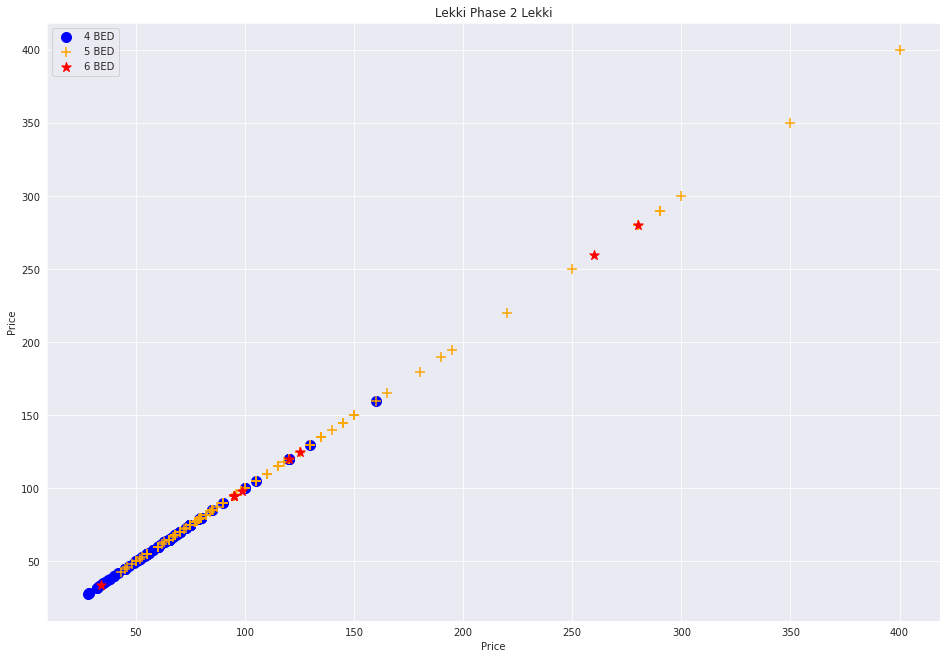

In [75]:
def plot_scatter_chart(df, area, types):
    bed4 = df[(df.area==area) & (df.bedroom==4) & (df.types==types)]
    bed5 = df[(df.area==area) & (df.bedroom==5) & (df.types==types)]
    bed6 = df[(df.area==area) & (df.bedroom==6) & (df.types==types)]
    matplotlib.rcParams['figure.figsize'] = (16,11)
    plt.scatter(bed4.price/1000000, bed4.price/1000000, color='blue', label='4 BED', s=100)
    plt.scatter(bed5.price/1000000, bed5.price/1000000, marker='+', color='orange', label='5 BED', s=100)
    plt.scatter(bed6.price/1000000, bed6.price/1000000, marker='*', color='red', label='6 BED', s=100)
    plt.xlabel("Price")
    plt.ylabel("Price")
    plt.title(area)
    plt.legend()
    plt.show()
    

plot_scatter_chart(properties_five, "Lekki Phase 2 Lekki", "detached_duplex")

### Function to remove outliers

In [76]:
def remove_bhk_outliers(df):
    exclude_indices = np.array([])
    for area, area_df in df.groupby('area'):
        for types, types_df in area_df.groupby('types'):
            bhk_stats = {}
            for bhk, bhk_df in types_df.groupby('bedroom'):
                bhk_stats[bhk] = {
                    'mean': np.mean(bhk_df.price),
                    'std': np.std(bhk_df.price),
                    'count': bhk_df.shape[0]
                }
            for bhk, bhk_df in types_df.groupby('bedroom'):
                stats = bhk_stats.get(bhk-1)
                if stats:
                    exclude_indices = np.append(exclude_indices, bhk_df[bhk_df.price<(stats['mean'])].index.values)
    return df.drop(exclude_indices, axis='index')

properties_six = remove_bhk_outliers(properties_five)

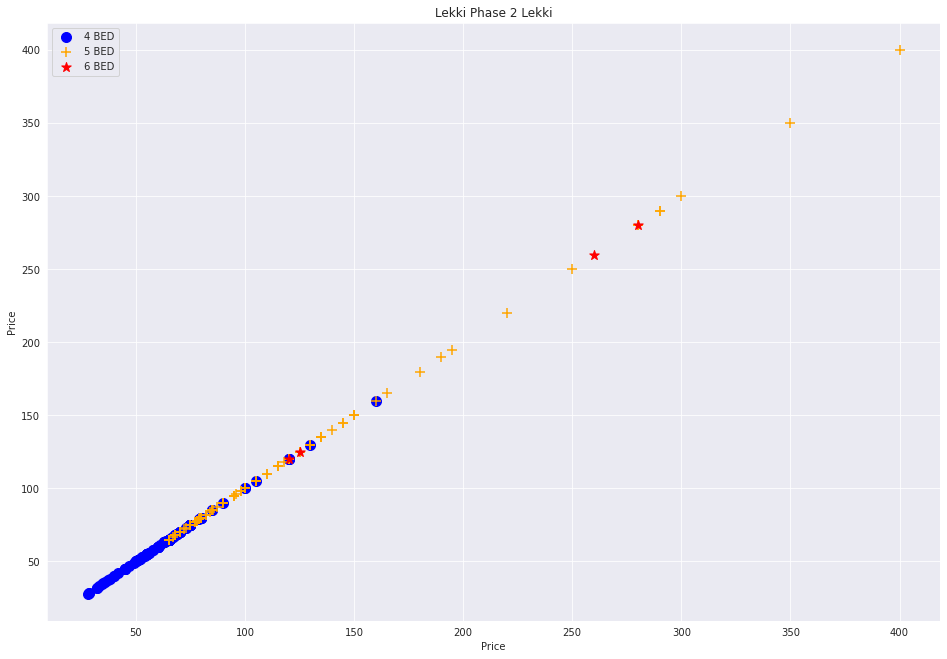

In [77]:
plot_scatter_chart(properties_six, "Lekki Phase 2 Lekki", "detached_duplex")

In [78]:
# View summary of the data
print("Rows   :", properties_six.shape[0])
print("Columns:", properties_six.shape[1])
print("\nFeatures:", properties_six.columns.tolist())
print("\nMissing values:", properties_six.isnull().sum().values.sum())
print('\nUnique values: \n', properties_six.nunique())

Rows   : 17116
Columns: 5

Features: ['types', 'area', 'bedroom', 'bathroom', 'price']

Missing values: 0

Unique values: 
 types         9
area        101
bedroom       5
bathroom      5
price       306
dtype: int64


In [79]:
properties_six.describe()

,bedroom,bathroom,price
count,17116.00,17116.00,17116.00
mean,4.26,4.50,114402736.00
std,0.69,0.81,117160928.00
min,3.00,3.00,14000000.00
25%,4.00,4.00,50000000.00
50%,4.00,4.00,72000000.00
75%,5.00,5.00,130000000.00
max,7.00,7.00,850000000.00


### Illustration

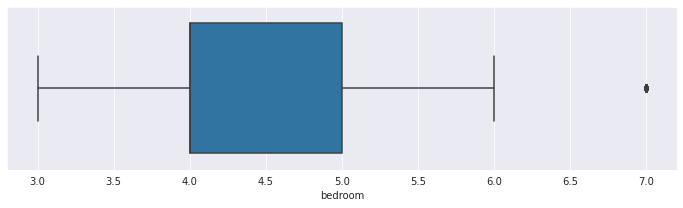

In [80]:
# For bedroom
fig, ax = plt.subplots(figsize=(12, 3))
sns.boxplot(x='bedroom', data=properties_six)
plt.show()

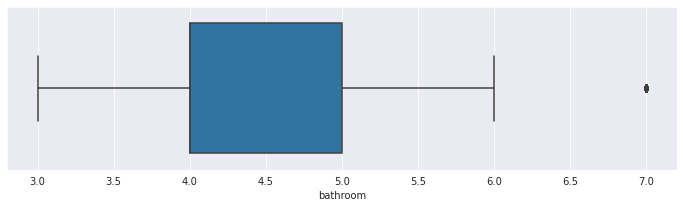

In [81]:
# For bathroom
fig, ax = plt.subplots(figsize=(12, 3))
sns.boxplot(x='bathroom', data=properties_six)
plt.show()

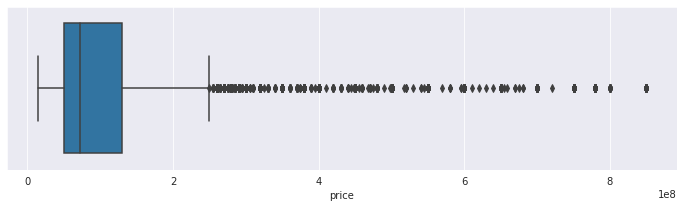

In [82]:
# For price
fig, ax = plt.subplots(figsize=(12, 3))
sns.boxplot(x='price', data=properties_six)
plt.show()

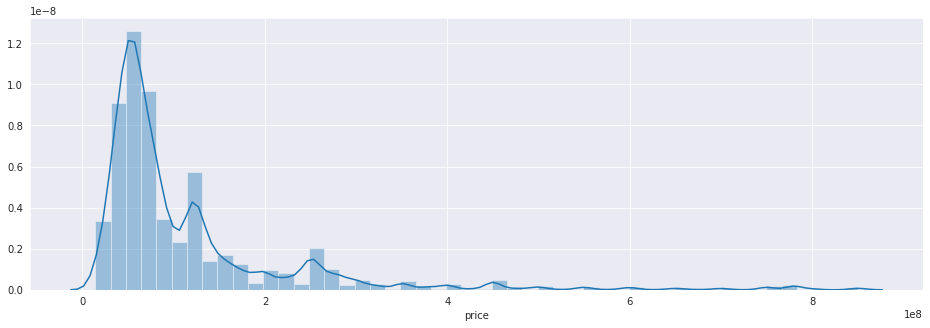

In [83]:
fig, ax = plt.subplots(figsize=(16, 5))
sns.distplot(properties_six.price, ax=ax)
plt.show()

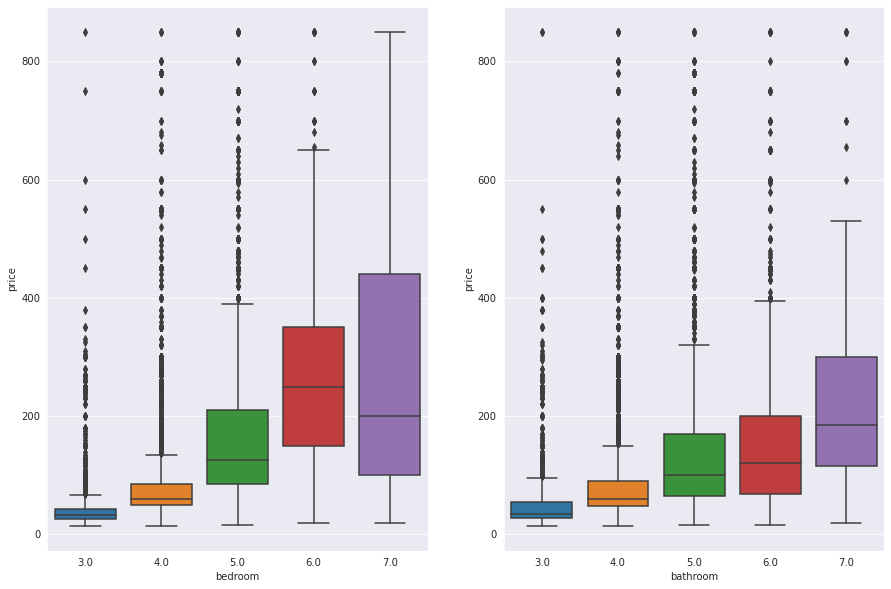

In [84]:
fig, axs = plt.subplots(ncols=2, figsize=(15, 10))
sns.boxplot(x='bedroom', y=properties_six.price/1000000, data=properties_six, orient='v',dodge=False, ax=axs[0])
sns.boxplot(x='bathroom', y=properties_six.price/1000000, data=properties_six, orient='v',dodge=False, ax=axs[1])
plt.show()

Remove outliers by bedroom, types and location

In [85]:
def remove_pps_outliers(df):
    df_out = pd.DataFrame()
    for area, area_df in df.groupby('area'):
        for types, types_df in area_df.groupby('types'):
            for key, subdf in types_df.groupby('bedroom'):
                m = np.mean(subdf.price)
                st = np.std(subdf.price)
                reduced_df = subdf[(subdf.price>(m-st)) & (subdf.price<=(m+st))]
                df_out = pd.concat([df_out, reduced_df], ignore_index=True)
    return df_out

properties_seven = remove_pps_outliers(properties_six)
properties_seven.shape

(13069, 5)

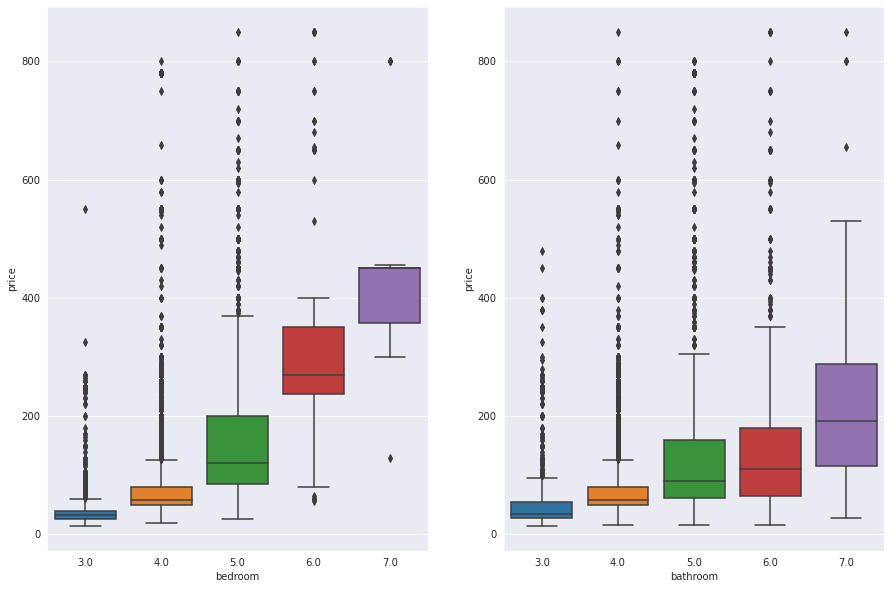

In [86]:
fig, axs = plt.subplots(ncols=2, figsize=(15, 10))
sns.boxplot(x='bedroom', y=properties_seven.price/1000000, data=properties_seven, orient='v',dodge=False, ax=axs[0])
sns.boxplot(x='bathroom', y=properties_seven.price/1000000, data=properties_seven, orient='v',dodge=False, ax=axs[1])
plt.show()

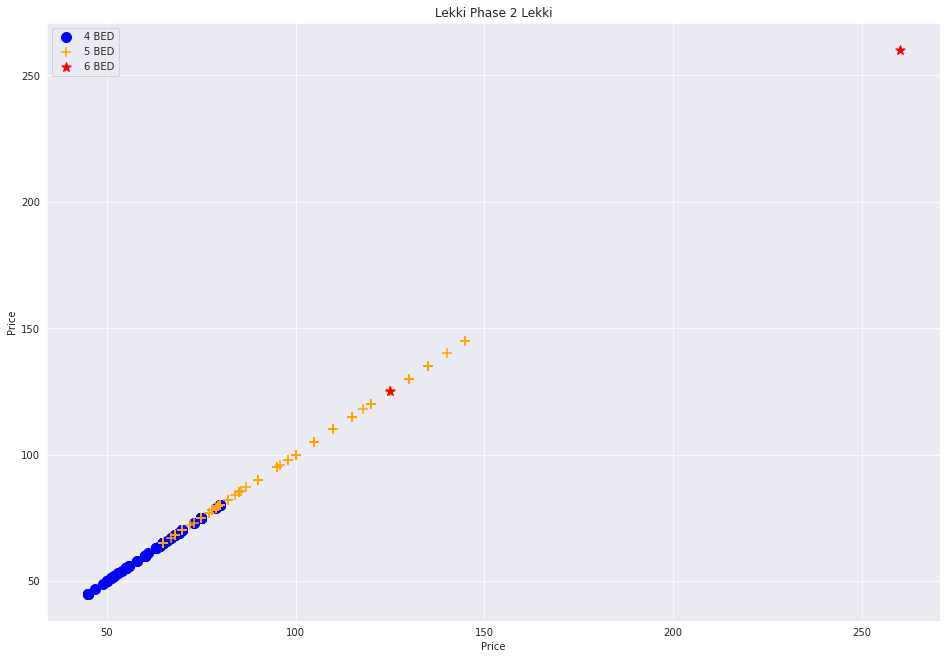

In [87]:
plot_scatter_chart(properties_seven, "Lekki Phase 2 Lekki", "detached_duplex")

In [88]:
# summary statistics of the data
properties_seven.describe()

,bedroom,bathroom,price
count,13069.00,13069.00,13069.00
mean,4.24,4.50,107069184.00
std,0.65,0.79,106687400.00
min,3.00,3.00,14000000.00
25%,4.00,4.00,50000000.00
50%,4.00,4.00,70000000.00
75%,5.00,5.00,120000000.00
max,7.00,7.00,850000000.00


In [89]:
#tab = properties_seven.pivot_table(index = ['area', 'types'],values = 'price') 
tab = properties_seven.pivot_table(index = 'area',values = 'price',columns = 'types')

In [90]:
tab.tail(10)

types,bungalow,detached_bungalow,detached_duplex,duplex,house,semi_detached_bungalow,semi_detached_duplex,terraced_bungalow,terraced_duplex
area,,,,,,,,,
Oribanwa Ibeju Lekki,nan,20000000.00,nan,nan,24956666.00,nan,33000000.00,nan,20596250.00
Osapa London Lekki,nan,280000000.00,195426176.00,135846160.00,101243904.00,63000000.00,76507776.00,nan,61694028.00
Osborne Ikoyi,nan,nan,300000000.00,200000000.00,150000000.00,nan,191428576.00,nan,146314448.00
Parkview Ikoyi,nan,nan,309393952.00,nan,185000000.00,nan,218235296.00,nan,nan
Pinnock Beach Estate Lekki,nan,nan,279062496.00,nan,nan,nan,135000000.00,nan,nan
Royal Garden Estate Ajah,nan,nan,140000000.00,nan,nan,nan,110000000.00,nan,83333336.00
Sangotedo Ajah,nan,38652344.00,54206200.00,51666668.00,37035716.00,16530120.00,40458332.00,41000000.00,34750000.00
Thomas Estate Ajah,nan,34045456.00,52246752.00,nan,32000000.00,35000000.00,43047620.00,nan,44857144.00
Vgc Ajah,nan,55000000.00,147662928.00,580000000.00,95833336.00,nan,60064104.00,nan,37500000.00


### Graph Illustrations of Property Types According To Top Locations

In [91]:
detached_duplex = tab[["detached_duplex"]].groupby(['area']).max().sort_values(by='detached_duplex', ascending=False)[:7]
pd.set_option('display.max_column', None)
detached_duplex

types,detached_duplex
area,
Banana Island Ikoyi,730900800.00
Old Ikoyi Ikoyi,485405408.00
Mojisola Onikoyi Estate Ikoyi,448333344.00
Ikoyi,379259264.00
Victoria Island,366000000.00
Nicon Town Lekki,329761920.00
Parkview Ikoyi,309393952.00


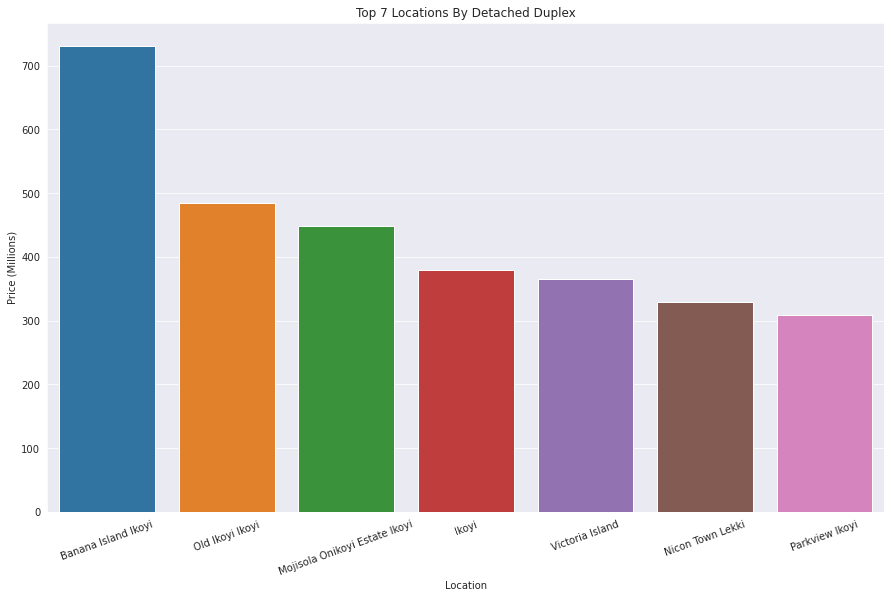

In [92]:
fig, ax = plt.subplots(figsize=(15, 9))
sns.barplot(x=detached_duplex.index, y=detached_duplex.detached_duplex/1000000, orient='v', dodge=False)
plt.xticks(rotation=20)
plt.xlabel("Location")
plt.ylabel("Price (Millions)")
plt.title('Top 7 Locations By Detached Duplex')
plt.show()

In [93]:
semi_detached_duplex = tab[["semi_detached_duplex"]].groupby(['area']).max().sort_values(by='semi_detached_duplex', ascending=False)[:7]
pd.set_option('display.max_column', None)
semi_detached_duplex

types,semi_detached_duplex
area,
Banana Island Ikoyi,401478880.00
Ikoyi,287037024.00
Mojisola Onikoyi Estate Ikoyi,283333344.00
Old Ikoyi Ikoyi,244848480.00
Victoria Island,227857136.00
Parkview Ikoyi,218235296.00
Nicon Town Lekki,213333328.00


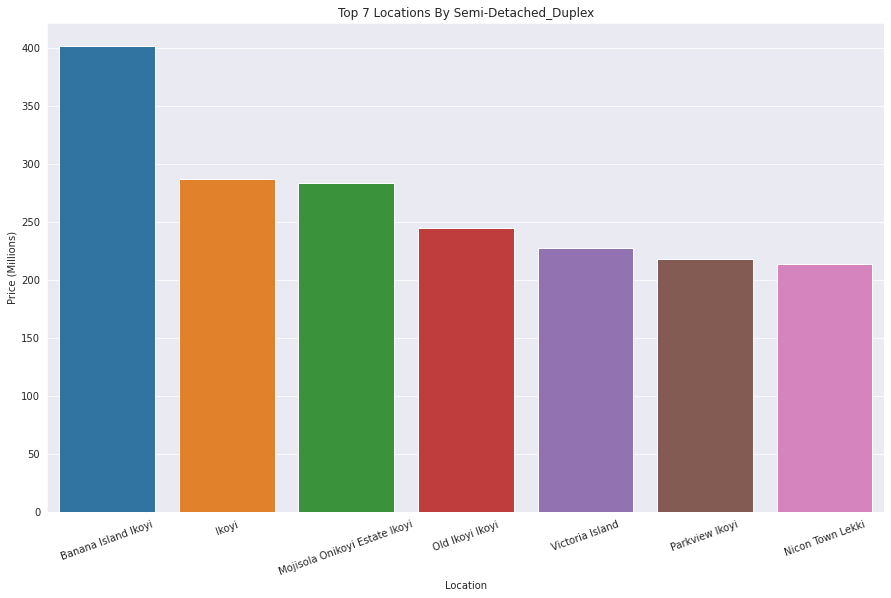

In [94]:
fig, ax = plt.subplots(figsize=(15, 9))
sns.barplot(x=semi_detached_duplex.index, y=semi_detached_duplex['semi_detached_duplex']/1000000, orient='v', dodge=False)
plt.xticks(rotation=20)
plt.xlabel("Location")
plt.ylabel("Price (Millions)")
plt.title('Top 7 Locations By Semi-Detached_Duplex')
plt.show()

In [95]:
terraced_duplex = tab[["terraced_duplex"]].groupby(['area']).max().sort_values(by='terraced_duplex', ascending=False)[:7]
pd.set_option('display.max_column', None)
terraced_duplex

types,terraced_duplex
area,
Banana Island Ikoyi,326527776.00
Old Ikoyi Ikoyi,247439648.00
Ikoyi,232083328.00
Mojisola Onikoyi Estate Ikoyi,206666672.00
Victoria Island,192150000.00
Omole Phase 2 Ikeja,180000000.00
Osborne Ikoyi,146314448.00


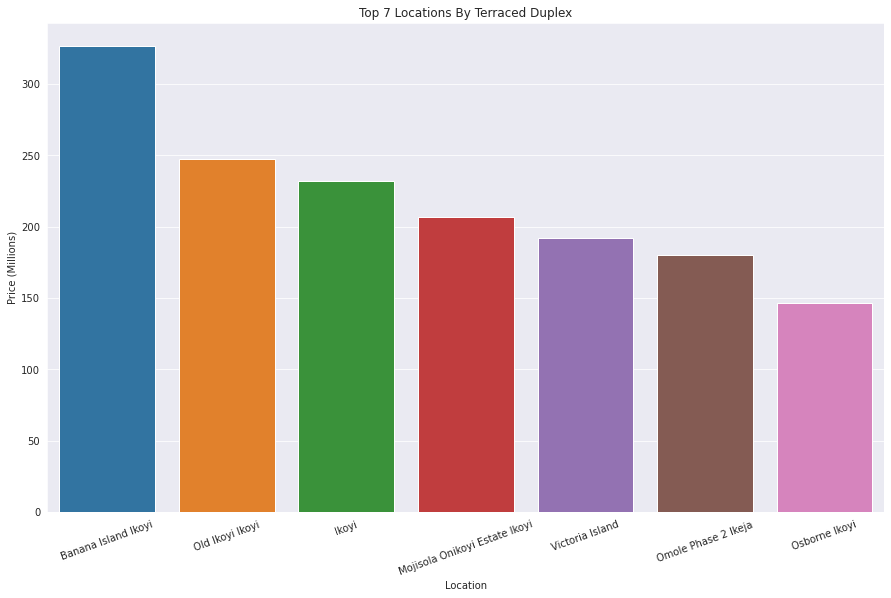

In [96]:
fig, ax = plt.subplots(figsize=(15, 9))
sns.barplot(x=terraced_duplex.index, y=terraced_duplex.terraced_duplex/1000000, orient='v', dodge=False)
plt.xticks(rotation=20)
plt.xlabel("Location")
plt.ylabel("Price (Millions)")
plt.title('Top 7 Locations By Terraced Duplex')
plt.show()

In [97]:
house = tab[["house"]].groupby(['area']).max().sort_values(by='house', ascending=False)[:7]
pd.set_option('display.max_column', None)
house

types,house
area,
Banana Island Ikoyi,429333344.00
Old Ikoyi Ikoyi,331124992.00
Ikoyi,289000000.00
Mojisola Onikoyi Estate Ikoyi,265000000.00
Victoria Island,250000000.00
Festac Amuwo Odofin,220000000.00
Parkview Ikoyi,185000000.00


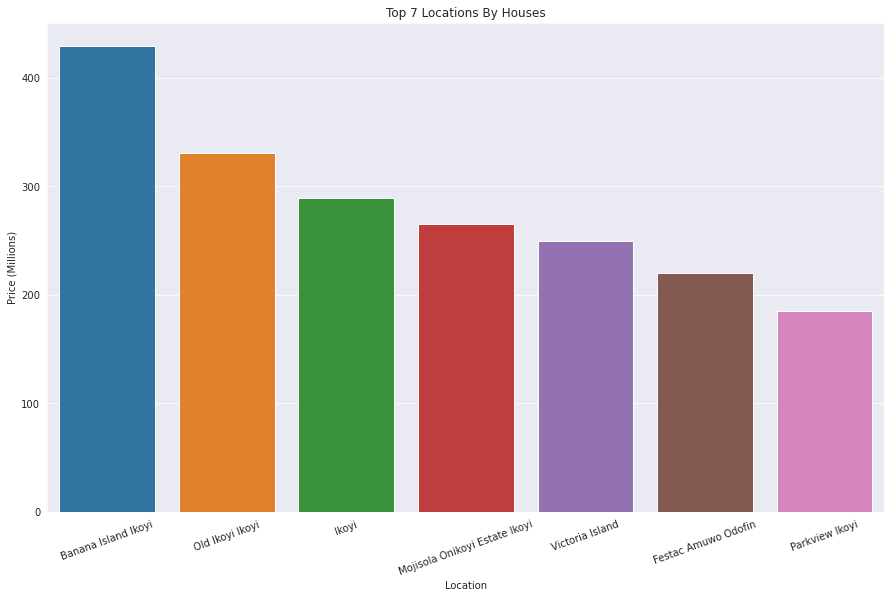

In [98]:
fig, ax = plt.subplots(figsize=(15, 9))
sns.barplot(x=house.index, y=house.house/1000000, orient='v', dodge=False)
plt.xticks(rotation=20)
plt.xlabel("Location")
plt.ylabel("Price (Millions)")
plt.title('Top 7 Locations By Houses')
plt.show()

In [99]:
detached_bungalow = tab[["detached_bungalow"]].groupby(['area']).max().sort_values(by='detached_bungalow', ascending=False)[:7]
pd.set_option('display.max_column', None)
detached_bungalow

types,detached_bungalow
area,
Osapa London Lekki,280000000.00
Lekki Phase 1,150000000.00
Bode Thomas Surulere,77666664.00
Ogunlana Surulere,60000000.00
Egbeda Alimosho,57000000.00
Vgc Ajah,55000000.00
Ikota Ajah,55000000.00


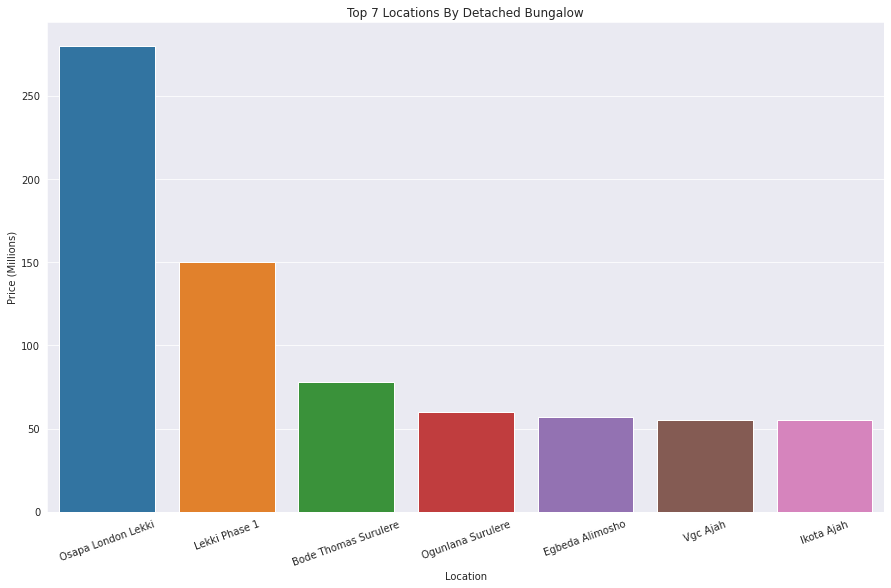

In [100]:
fig, ax = plt.subplots(figsize=(15, 9))
sns.barplot(x=detached_bungalow.index, y=detached_bungalow.detached_bungalow/1000000, orient='v', dodge=False)
plt.xticks(rotation=20)
plt.xlabel("Location")
plt.ylabel("Price (Millions)")
plt.title('Top 7 Locations By Detached Bungalow')
plt.show()

In [101]:
duplex = tab[["duplex"]].groupby(['area']).max().sort_values(by='duplex', ascending=False)[:7]
pd.set_option('display.max_column', None)
duplex

types,duplex
area,
Victoria Island,600000000.00
Vgc Ajah,580000000.00
G R A Ikeja,550000000.00
Banana Island Ikoyi,503750016.00
Adeniyi Jones Ikeja,498000000.00
Maryland Maryland,300000000.00
Old Ikoyi Ikoyi,248333328.00


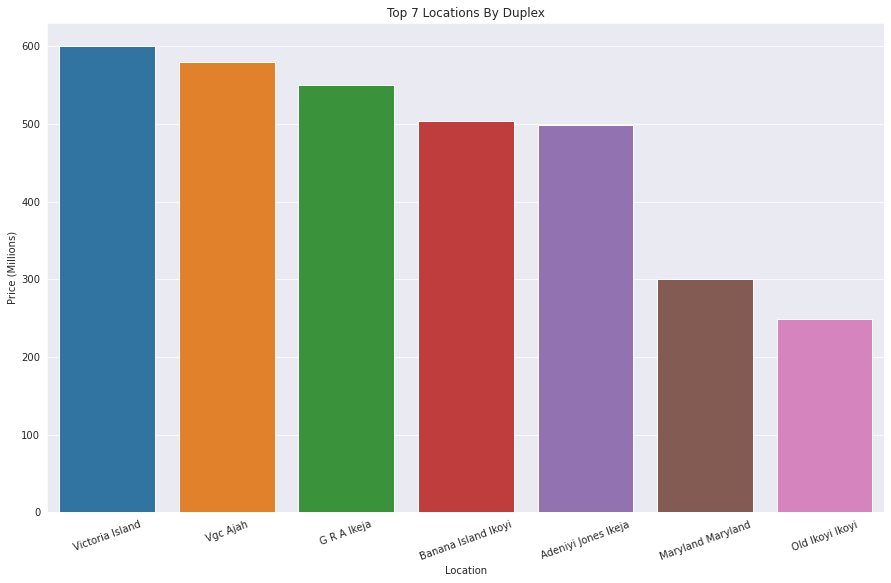

In [102]:
fig, ax = plt.subplots(figsize=(15, 9))
sns.barplot(x=duplex.index, y=duplex.duplex/1000000, orient='v', dodge=False)
plt.xticks(rotation=20)
plt.xlabel("Location")
plt.ylabel("Price (Millions)")
plt.title('Top 7 Locations By Duplex')
plt.show()

In [103]:
semi_detached_bungalow = tab[["semi_detached_bungalow"]].groupby(['area']).max().sort_values(by='semi_detached_bungalow', ascending=False)[:7]
pd.set_option('display.max_column', None)
semi_detached_bungalow 

types,semi_detached_bungalow
area,
Lekki Phase 1,135000000.00
Osapa London Lekki,63000000.00
Chervon Lekki,61833332.00
Ikate Lekki,53500000.00
Ikota Ajah,52333332.00
Lekki Phase 2 Lekki,52000000.00
Lafiaji Lekki,40500000.00


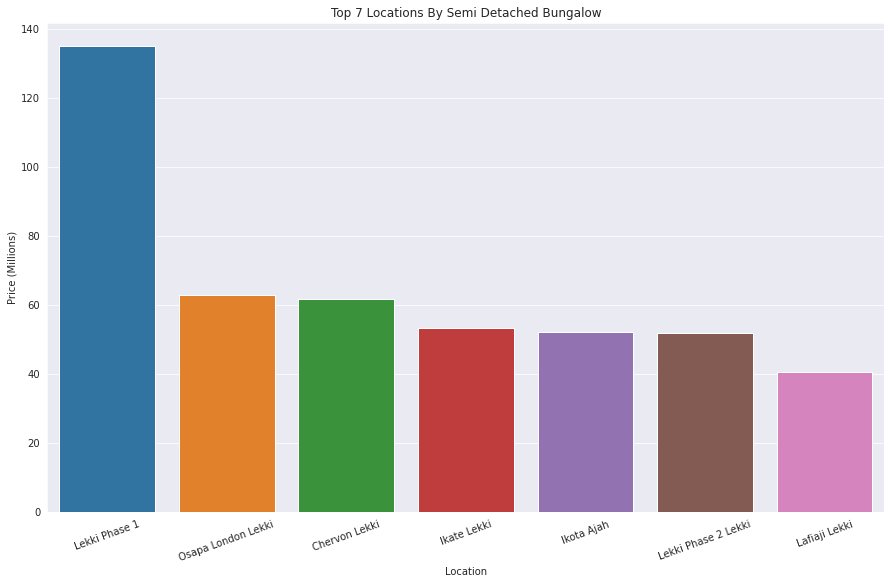

In [104]:
fig, ax = plt.subplots(figsize=(15, 9))
sns.barplot(x=semi_detached_bungalow.index, y=semi_detached_bungalow.semi_detached_bungalow/1000000, orient='v', dodge=False)
plt.xticks(rotation=20)
plt.xlabel("Location")
plt.ylabel("Price (Millions)")
plt.title('Top 7 Locations By Semi Detached Bungalow')
plt.show()

#### One hot encoding - area and type columns

Since machine learning models cannot intepret text/categorical data, so we have to convert location and type columns to numeric data using one hot encoding

In [105]:
area_dummies = pd.get_dummies(properties_seven.area)
area_dummies.head()

,2nd Toll Gate Lekki,Abijo Ibeju Lekki,Abraham Adesanya Ajah,Abule Egba Agege,Adeniyi Jones Ikeja,Ado Ajah,Ago Palace Isolo,Aguda Surulere,Agungi Lekki,Ajah,Ajiwe Ajah,Allen Ikeja,Anthony Maryland,Awoyaya Ibeju Lekki,Badore Ajah,Banana Island Ikoyi,Bode Thomas Surulere,Bogije Ibeju Lekki,Chervon Lekki,Chevy View Estate Ajah,Crown Estate Ajah,Ebute Ikorodu,Egbeda Alimosho,Eleko Ibeju Lekki,Fagba Agege,Festac Amuwo Odofin,G R A Ikeja,G R A Isheri North,G R A Magodo,G R A Ogudu,Gbagada Phase 1 Gbagada,Idado Lekki,Ifako Gbagada,Igando Ikotun,Igbo Efon Lekki,Igbogbo Ikorodu,Ijegun Ikotun,Ikate Lekki,Ikota Ajah,Ikoyi,Ilaje Ajah,Ilasan Lekki,Ilupeju Estate Ilupeju,Isheri Olofin Alimosho,Jakande Lekki,Lafiaji Lekki,Lakowe Ibeju Lekki,Lekki,Lekki Expressway Lekki,Lekki Gardens Estate Ajah,Lekki Phase 1,Lekki Phase 2 Lekki,Maryland Maryland,Mende Maryland,Mojisola Onikoyi Estate Ikoyi,Nicon Town Lekki,Ogba Ikeja,Ogombo Ajah,Ogunlana Surulere,Oke Afa Isolo,Oko Oba Agege,Old Ikoyi Ikoyi,Ologolo Lekki,Olokonla Ajah,Omole Phase 1 Ikeja,Omole Phase 1 Ojodu,Omole Phase 2 Ikeja,Oniru Vi,Opebi Ikeja,Opic Isheri North,Oral Estate Lekki,Orchid Road Lekki,Oregun Ikeja,Oribanwa Ibeju Lekki,Osapa London Lekki,Osborne Ikoyi,Parkview Ikoyi,Pinnock Beach Estate Lekki,Royal Garden Estate Ajah,Sangotedo Ajah,Thomas Estate Ajah,Vgc Ajah,Victoria Island
0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
1,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
2,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
3,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
4,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0


In [106]:
type_dummies = pd.get_dummies(properties_seven.types)
type_dummies.head()

,bungalow,detached_bungalow,detached_duplex,duplex,house,semi_detached_bungalow,semi_detached_duplex,terraced_bungalow,terraced_duplex
0,0,0,1,0,0,0,0,0,0
1,0,0,1,0,0,0,0,0,0
2,0,0,1,0,0,0,0,0,0
3,0,0,1,0,0,0,0,0,0
4,0,0,1,0,0,0,0,0,0


#### Avoid dummy variable trap

Machine Learning algorithms assumes that,dataframe columns are linearly independent,means we can not predict values of one column if we combine remaining columns.This is called linear independence. If columns are linearly dependent then accuracy of models is reduced.So we need to reduce this type of dependence.

So I would drop one of the dummy variables to avoid redundancy.

This can also be done by including - drop_first=True in the get_dummies()

In [107]:
#Concat new columns to original dataframe 
properties_eight = pd.concat([properties_seven, type_dummies.drop("bungalow", axis='columns'), area_dummies.drop("Abule Egba Agege", axis='columns')], axis='columns')
properties_eight.head()

,types,area,bedroom,bathroom,price,detached_bungalow,detached_duplex,duplex,house,semi_detached_bungalow,semi_detached_duplex,terraced_bungalow,terraced_duplex,2nd Toll Gate Lekki,Abijo Ibeju Lekki,Abraham Adesanya Ajah,Adeniyi Jones Ikeja,Ado Ajah,Ago Palace Isolo,Aguda Surulere,Agungi Lekki,Ajah,Ajiwe Ajah,Allen Ikeja,Anthony Maryland,Awoyaya Ibeju Lekki,Badore Ajah,Banana Island Ikoyi,Bode Thomas Surulere,Bogije Ibeju Lekki,Chervon Lekki,Chevy View Estate Ajah,Crown Estate Ajah,Ebute Ikorodu,Egbeda Alimosho,Eleko Ibeju Lekki,Fagba Agege,Festac Amuwo Odofin,G R A Ikeja,G R A Isheri North,G R A Magodo,G R A Ogudu,Gbagada Phase 1 Gbagada,Idado Lekki,Ifako Gbagada,Igando Ikotun,Igbo Efon Lekki,Igbogbo Ikorodu,Ijegun Ikotun,Ikate Lekki,Ikota Ajah,Ikoyi,Ilaje Ajah,Ilasan Lekki,Ilupeju Estate Ilupeju,Isheri Olofin Alimosho,Jakande Lekki,Lafiaji Lekki,Lakowe Ibeju Lekki,Lekki,Lekki Expressway Lekki,Lekki Gardens Estate Ajah,Lekki Phase 1,Lekki Phase 2 Lekki,Maryland Maryland,Mende Maryland,Mojisola Onikoyi Estate Ikoyi,Nicon Town Lekki,Ogba Ikeja,Ogombo Ajah,Ogunlana Surulere,Oke Afa Isolo,Oko Oba Agege,Old Ikoyi Ikoyi,Ologolo Lekki,Olokonla Ajah,Omole Phase 1 Ikeja,Omole Phase 1 Ojodu,Omole Phase 2 Ikeja,Oniru Vi,Opebi Ikeja,Opic Isheri North,Oral Estate Lekki,Orchid Road Lekki,Oregun Ikeja,Oribanwa Ibeju Lekki,Osapa London Lekki,Osborne Ikoyi,Parkview Ikoyi,Pinnock Beach Estate Lekki,Royal Garden Estate Ajah,Sangotedo Ajah,Thomas Estate Ajah,Vgc Ajah,Victoria Island
0,detached_duplex,2nd Toll Gate Lekki,4.00,5.00,65000000.00,0,1,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
1,detached_duplex,2nd Toll Gate Lekki,4.00,4.00,75000000.00,0,1,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
2,detached_duplex,2nd Toll Gate Lekki,4.00,4.00,60000000.00,0,1,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
3,detached_duplex,2nd Toll Gate Lekki,4.00,5.00,75000000.00,0,1,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
4,detached_duplex,2nd Toll Gate Lekki,4.00,5.00,67000000.00,0,1,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0


#### Drop area and type columns as they are not needed again

In [108]:
properties_nine = properties_eight.drop(["types", "area"], axis="columns")

properties_nine.head()

,bedroom,bathroom,price,detached_bungalow,detached_duplex,duplex,house,semi_detached_bungalow,semi_detached_duplex,terraced_bungalow,terraced_duplex,2nd Toll Gate Lekki,Abijo Ibeju Lekki,Abraham Adesanya Ajah,Adeniyi Jones Ikeja,Ado Ajah,Ago Palace Isolo,Aguda Surulere,Agungi Lekki,Ajah,Ajiwe Ajah,Allen Ikeja,Anthony Maryland,Awoyaya Ibeju Lekki,Badore Ajah,Banana Island Ikoyi,Bode Thomas Surulere,Bogije Ibeju Lekki,Chervon Lekki,Chevy View Estate Ajah,Crown Estate Ajah,Ebute Ikorodu,Egbeda Alimosho,Eleko Ibeju Lekki,Fagba Agege,Festac Amuwo Odofin,G R A Ikeja,G R A Isheri North,G R A Magodo,G R A Ogudu,Gbagada Phase 1 Gbagada,Idado Lekki,Ifako Gbagada,Igando Ikotun,Igbo Efon Lekki,Igbogbo Ikorodu,Ijegun Ikotun,Ikate Lekki,Ikota Ajah,Ikoyi,Ilaje Ajah,Ilasan Lekki,Ilupeju Estate Ilupeju,Isheri Olofin Alimosho,Jakande Lekki,Lafiaji Lekki,Lakowe Ibeju Lekki,Lekki,Lekki Expressway Lekki,Lekki Gardens Estate Ajah,Lekki Phase 1,Lekki Phase 2 Lekki,Maryland Maryland,Mende Maryland,Mojisola Onikoyi Estate Ikoyi,Nicon Town Lekki,Ogba Ikeja,Ogombo Ajah,Ogunlana Surulere,Oke Afa Isolo,Oko Oba Agege,Old Ikoyi Ikoyi,Ologolo Lekki,Olokonla Ajah,Omole Phase 1 Ikeja,Omole Phase 1 Ojodu,Omole Phase 2 Ikeja,Oniru Vi,Opebi Ikeja,Opic Isheri North,Oral Estate Lekki,Orchid Road Lekki,Oregun Ikeja,Oribanwa Ibeju Lekki,Osapa London Lekki,Osborne Ikoyi,Parkview Ikoyi,Pinnock Beach Estate Lekki,Royal Garden Estate Ajah,Sangotedo Ajah,Thomas Estate Ajah,Vgc Ajah,Victoria Island
0,4.00,5.00,65000000.00,0,1,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
1,4.00,4.00,75000000.00,0,1,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
2,4.00,4.00,60000000.00,0,1,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
3,4.00,5.00,75000000.00,0,1,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
4,4.00,5.00,67000000.00,0,1,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0


In [109]:
# View summary of the data
print("Rows   :", properties_nine.shape[0])
print("Columns:", properties_nine.shape[1])
print("\nMissing values:", properties_nine.isnull().sum().values.sum())

Rows   : 13069
Columns: 93

Missing values: 0


### Model building

In [110]:
# independent variables only
X = properties_nine.drop('price', axis='columns')
X.head()

,bedroom,bathroom,detached_bungalow,detached_duplex,duplex,house,semi_detached_bungalow,semi_detached_duplex,terraced_bungalow,terraced_duplex,2nd Toll Gate Lekki,Abijo Ibeju Lekki,Abraham Adesanya Ajah,Adeniyi Jones Ikeja,Ado Ajah,Ago Palace Isolo,Aguda Surulere,Agungi Lekki,Ajah,Ajiwe Ajah,Allen Ikeja,Anthony Maryland,Awoyaya Ibeju Lekki,Badore Ajah,Banana Island Ikoyi,Bode Thomas Surulere,Bogije Ibeju Lekki,Chervon Lekki,Chevy View Estate Ajah,Crown Estate Ajah,Ebute Ikorodu,Egbeda Alimosho,Eleko Ibeju Lekki,Fagba Agege,Festac Amuwo Odofin,G R A Ikeja,G R A Isheri North,G R A Magodo,G R A Ogudu,Gbagada Phase 1 Gbagada,Idado Lekki,Ifako Gbagada,Igando Ikotun,Igbo Efon Lekki,Igbogbo Ikorodu,Ijegun Ikotun,Ikate Lekki,Ikota Ajah,Ikoyi,Ilaje Ajah,Ilasan Lekki,Ilupeju Estate Ilupeju,Isheri Olofin Alimosho,Jakande Lekki,Lafiaji Lekki,Lakowe Ibeju Lekki,Lekki,Lekki Expressway Lekki,Lekki Gardens Estate Ajah,Lekki Phase 1,Lekki Phase 2 Lekki,Maryland Maryland,Mende Maryland,Mojisola Onikoyi Estate Ikoyi,Nicon Town Lekki,Ogba Ikeja,Ogombo Ajah,Ogunlana Surulere,Oke Afa Isolo,Oko Oba Agege,Old Ikoyi Ikoyi,Ologolo Lekki,Olokonla Ajah,Omole Phase 1 Ikeja,Omole Phase 1 Ojodu,Omole Phase 2 Ikeja,Oniru Vi,Opebi Ikeja,Opic Isheri North,Oral Estate Lekki,Orchid Road Lekki,Oregun Ikeja,Oribanwa Ibeju Lekki,Osapa London Lekki,Osborne Ikoyi,Parkview Ikoyi,Pinnock Beach Estate Lekki,Royal Garden Estate Ajah,Sangotedo Ajah,Thomas Estate Ajah,Vgc Ajah,Victoria Island
0,4.00,5.00,0,1,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
1,4.00,4.00,0,1,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
2,4.00,4.00,0,1,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
3,4.00,5.00,0,1,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
4,4.00,5.00,0,1,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0


In [111]:
# dependent/target variable
y = properties_nine.price
y.head()

0   65000000.00
1   75000000.00
2   60000000.00
3   75000000.00
4   67000000.00
Name: price, dtype: float32

In [112]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=10, shuffle=True)

In [113]:
dec_clf = DecisionTreeRegressor(splitter="random")
dec_clf.fit(X_train, y_train)
dec_clf.score(X_train,y_train)

0.9697678855882254

In [114]:
dec_clf.score(X_test, y_test)

0.9512800094274457

In [115]:
cv = ShuffleSplit(n_splits=5, test_size=0.2, random_state=0)

cross_val_score(DecisionTreeRegressor(), X, y, cv=cv)

array([0.95569635, 0.9360542 , 0.94537538, 0.95006018, 0.9333815 ])

In [116]:
def find_best_model_using_gridsearchcv(X,y):
    algos = {
        'linear_regression': {
            'model': LinearRegression(),
            'params': {
                'normalize': [True, False]
            }
        },
        'lasso': {
            'model': Lasso(),
            'params': {
                'alpha': [1,2],
                'selection': ['random', 'cyclic']
            }
        },
        'decision_tree': {
            'model': DecisionTreeRegressor(),
             'params': {
                'criterion': ['mse', 'friedman_mse'],
                'splitter': ['best', 'random']
            }
        },
           'random_forest': {
            'model': RandomForestRegressor(),
            'params': {
                'max_features': ['auto', 'sqrt', 'log2']
            }
        }
    }
    scores = []
    cv = ShuffleSplit(n_splits=5, test_size=0.2, random_state=0)
    for algo_name, config in algos.items():
        gs = GridSearchCV(config['model'], config['params'], cv=cv, return_train_score=False)
        gs.fit(X,y)
        scores.append({
            'model': algo_name,
            'best_score': gs.best_score_,
            'best_params': gs.best_params_
        })
        
    return pd.DataFrame(scores, columns=['model', 'best_score', 'best_params'])

find_best_model_using_gridsearchcv(X,y)

,model,best_score,best_params
0,linear_regression,-1682279173678580629504.00,{'normalize': False}
1,lasso,0.80,"{'alpha': 2, 'selection': 'cyclic'}"
2,decision_tree,0.95,"{'criterion': 'friedman_mse', 'splitter': 'ran..."
3,random_forest,0.95,{'max_features': 'sqrt'}


In [117]:
rf_reg = RandomForestRegressor(random_state=0, max_features = 'sqrt')
rf_reg.fit(X_train,y_train)
rf_reg.score(X_train,y_train)

0.9671010803147645

In [118]:
rf_reg.score(X_test,y_test)

0.9532205052693452

In [119]:
X.columns[:13]

Index(['bedroom', 'bathroom', 'detached_bungalow', 'detached_duplex', 'duplex',
       'house', 'semi_detached_bungalow', 'semi_detached_duplex',
       'terraced_bungalow', 'terraced_duplex', '2nd Toll Gate Lekki',
       'Abijo Ibeju Lekki', 'Abraham Adesanya Ajah'],
      dtype='object')

In [120]:
np.where(X.columns=="2nd Toll Gate Lekki")[0][0]

10

In [121]:
def predict_price(area, types, bedroom, bathroom):
    area_index = np.where(X.columns==area)[0][0]
    types_index = np.where(X.columns==types)[0][0]
    
    x = np.zeros(len(X.columns))
    x[0] = bedroom
    x[1] = bathroom
    if area_index >= 0:
        x[area_index] = 1
    if types_index >= 0:
        x[types_index] = 1
        
    return rf_reg.predict([x])[0]

In [122]:
predict_price('2nd Toll Gate Lekki', 'detached_duplex', 4, 4)

69226380.95238094

In [123]:
predict_price('2nd Toll Gate Lekki', 'semi_detached_duplex', 3, 3)

38971666.666666664

In [124]:
compare_price = properties_seven[properties_seven['area'].str.contains('Ikeja')]
compare_price.head(15)

,types,area,bedroom,bathroom,price
216,detached_duplex,Adeniyi Jones Ikeja,4.00,4.00,90000000.00
217,detached_duplex,Adeniyi Jones Ikeja,4.00,4.00,65000000.00
218,detached_duplex,Adeniyi Jones Ikeja,4.00,4.00,65000000.00
219,detached_duplex,Adeniyi Jones Ikeja,4.00,4.00,70000000.00
220,detached_duplex,Adeniyi Jones Ikeja,4.00,4.00,65000000.00
221,detached_duplex,Adeniyi Jones Ikeja,4.00,5.00,65000000.00
222,detached_duplex,Adeniyi Jones Ikeja,4.00,5.00,60000000.00
223,detached_duplex,Adeniyi Jones Ikeja,5.00,5.00,110000000.00
224,detached_duplex,Adeniyi Jones Ikeja,5.00,5.00,135000000.00
225,detached_duplex,Adeniyi Jones Ikeja,5.00,5.00,135000000.00


In [125]:
predict_price('Adeniyi Jones Ikeja', 'detached_duplex', 5, 5)

125859155.77112947

In [126]:
predict_price('Omole Phase 1 Ikeja', 'detached_duplex', 5, 5)

131586208.6339379

In [127]:
oniru_prices = properties_seven[properties_seven['area'].str.contains('Oniru Vi')]
oniru_prices.head(10)

,types,area,bedroom,bathroom,price
10949,detached_duplex,Oniru Vi,4.00,5.00,120000000.00
10950,detached_duplex,Oniru Vi,4.00,5.00,120000000.00
10951,detached_duplex,Oniru Vi,4.00,4.00,160000000.00
10952,detached_duplex,Oniru Vi,4.00,4.00,145000000.00
10953,detached_duplex,Oniru Vi,4.00,4.00,130000000.00
10954,detached_duplex,Oniru Vi,4.00,4.00,165000000.00
10955,detached_duplex,Oniru Vi,4.00,5.00,125000000.00
10956,detached_duplex,Oniru Vi,4.00,4.00,150000000.00
10957,detached_duplex,Oniru Vi,4.00,3.00,120000000.00
10958,detached_duplex,Oniru Vi,4.00,6.00,165000000.00


In [128]:
predict_price('Oniru Vi', 'detached_duplex', 4, 4)

149632182.53968257

In [129]:
predict_price('Oniru Vi', 'semi_detached_bungalow', 3, 3)

64472893.34705659

### Function to match house types to location

In [130]:
locality = properties_seven.pivot_table(index = 'types',values = 'price',columns = 'area')

locality.tail()

area,2nd Toll Gate Lekki,Abijo Ibeju Lekki,Abraham Adesanya Ajah,Abule Egba Agege,Adeniyi Jones Ikeja,Ado Ajah,Ago Palace Isolo,Aguda Surulere,Agungi Lekki,Ajah,Ajiwe Ajah,Allen Ikeja,Anthony Maryland,Awoyaya Ibeju Lekki,Badore Ajah,Banana Island Ikoyi,Bode Thomas Surulere,Bogije Ibeju Lekki,Chervon Lekki,Chevy View Estate Ajah,Crown Estate Ajah,Ebute Ikorodu,Egbeda Alimosho,Eleko Ibeju Lekki,Fagba Agege,Festac Amuwo Odofin,G R A Ikeja,G R A Isheri North,G R A Magodo,G R A Ogudu,Gbagada Phase 1 Gbagada,Idado Lekki,Ifako Gbagada,Igando Ikotun,Igbo Efon Lekki,Igbogbo Ikorodu,Ijegun Ikotun,Ikate Lekki,Ikota Ajah,Ikoyi,Ilaje Ajah,Ilasan Lekki,Ilupeju Estate Ilupeju,Isheri Olofin Alimosho,Jakande Lekki,Lafiaji Lekki,Lakowe Ibeju Lekki,Lekki,Lekki Expressway Lekki,Lekki Gardens Estate Ajah,Lekki Phase 1,Lekki Phase 2 Lekki,Maryland Maryland,Mende Maryland,Mojisola Onikoyi Estate Ikoyi,Nicon Town Lekki,Ogba Ikeja,Ogombo Ajah,Ogunlana Surulere,Oke Afa Isolo,Oko Oba Agege,Old Ikoyi Ikoyi,Ologolo Lekki,Olokonla Ajah,Omole Phase 1 Ikeja,Omole Phase 1 Ojodu,Omole Phase 2 Ikeja,Oniru Vi,Opebi Ikeja,Opic Isheri North,Oral Estate Lekki,Orchid Road Lekki,Oregun Ikeja,Oribanwa Ibeju Lekki,Osapa London Lekki,Osborne Ikoyi,Parkview Ikoyi,Pinnock Beach Estate Lekki,Royal Garden Estate Ajah,Sangotedo Ajah,Thomas Estate Ajah,Vgc Ajah,Victoria Island
types,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
house,56500000.00,26142858.00,29000000.00,nan,140000000.00,nan,nan,37000000.00,65142856.00,40000000.00,37916668.00,nan,nan,35000000.00,47000000.00,429333344.00,nan,27000000.00,61075000.00,55000000.00,nan,nan,nan,44000000.00,80000000.00,220000000.00,184285712.00,nan,81636360.00,77500000.00,180000000.00,98000000.00,nan,nan,nan,nan,nan,119276192.00,60000000.00,289000000.00,nan,52000000.00,nan,45000000.00,80000000.00,42250000.00,nan,71622224.00,51333332.00,nan,168744688.00,61166668.00,nan,nan,265000000.00,nan,37000000.00,35000000.00,100000000.00,nan,30000000.00,331124992.00,nan,nan,nan,nan,70000000.00,126722224.00,86000000.00,nan,50000000.00,nan,nan,24956666.00,101243904.00,150000000.00,185000000.00,nan,nan,37035716.00,32000000.00,95833336.00,250000000.00
semi_detached_bungalow,nan,22700000.00,21800000.00,nan,nan,nan,nan,nan,nan,nan,24400000.00,nan,nan,31750000.00,nan,nan,40000000.00,nan,61833332.00,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,53500000.00,52333332.00,nan,nan,nan,nan,nan,nan,40500000.00,nan,nan,nan,nan,135000000.00,52000000.00,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,63000000.00,nan,nan,nan,nan,16530120.00,35000000.00,nan,nan
semi_detached_duplex,52824076.00,39666668.00,48800000.00,nan,94312496.00,38529412.00,nan,nan,60446152.00,44742424.00,48756412.00,80720000.00,78000000.00,27500000.00,43625000.00,401478880.00,nan,26486414.00,55388680.00,57588708.00,46200000.00,nan,nan,78500000.00,nan,nan,146428576.00,50000000.00,77433336.00,104375000.00,55000000.00,56723076.00,63333332.00,nan,54148484.00,nan,nan,106113208.00,54928412.00,287037024.00,44071428.00,68142856.00,90000000.00,nan,68840912.00,54215348.00,nan,61098216.00,50835364.00,30000000.00,129536280.00,55001748.00,75000000.00,65550000.00,283333344.00,213333328.00,62500000.00,50687500.00,nan,nan,nan,244848480.00,50262376.00,37750000.00,56461540.00,nan,71055552.00,155648144.00,60600000.00,37166668.00,55550000.00,49714284.00,nan,33000000.00,76507776.00,191428576.00,218235296.00,135000000.00,110000000.00,40458332.00,43047620.00,60064104.00,227857136.00
terraced_bungalow,nan,nan,41000000.00,nan,nan,nan,nan,nan,nan,nan,50000000.00,nan,nan,nan,nan,nan,nan,19299376.00,nan,nan,nan,nan,nan,nan,nan,nan,nan,30000000.00,nan,nan,nan,nan,nan,nan,nan,nan,nan,85000000.00,38000000.00,nan,nan,nan,nan,nan,nan,36000000.00,nan,nan,nan,nan,nan,35000000.00,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,41000000.00,nan,nan,nan
terraced_duplex,38842

In [131]:
properties_seven.to_csv("./data/properties.csv")

In [132]:
def match_area_with_types(area):
    check = locality[[area]].groupby("types", as_index=True).max().sort_values(by=area, ascending=False)
    check.reset_index(inplace = True)
    my_list = check.values
    avail_areas = []

    for x in my_list:
        if not pd.isna(x[1]):
            avail_areas.append(x[0])
            
    return avail_areas   

In [133]:
match_area_with_types('Ado Ajah')

['detached_duplex',
 'semi_detached_duplex',
 'terraced_duplex',
 'detached_bungalow',
 'duplex']

In [134]:
np.where(np.array(match_area_with_types('Ado Ajah')) == "semi_detached_duplex")[0][0]
#types_index = np.where(np.array(match_area_with_types(area)) == types)[0][0]

1

In [135]:
with open('./data/lagos_home_prices_model.pickle', 'wb') as f:
    pickle.dump(rf_reg, f)

In [136]:
columns = {
    'data_columns': [col.lower() for col in X.columns]
}
with open('./data/columns.json', 'w') as f:
    f.write(json.dumps(columns))